In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import os
import numpy as np
import datetime
import ast
import time
import re
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
#from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D
pd.set_option("display.max_colwidth",None)
#pip install keras_nlp
#from keras_nlp.layers import PositionEmbedding

import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# This notebook shall train ML model for predicting resolution of alerts.
# ML model used are SVM , RF, XG Boost

In [4]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("comb_data_ind_final3")
df = mydataset.get_dataframe()

## Traning data till September

In [5]:
df.sort_values("D_UPDATED_DTM",ascending=False,inplace=True)

# -------------------------------------------------------------------------------- NOTEBOOK-CELL: CODE
df["D_UPDATED_DTM"]=pd.to_datetime(df["D_UPDATED_DTM"],infer_datetime_format=True)
df.loc[:,["D_UPDATED_DTM"]].info()
df["D_UPDATED_DTM"]=df["D_UPDATED_DTM"].apply(lambda x: x.date())


# -------------------------------------------------------------------------------- NOTEBOOK-CELL: CODE
var1=datetime.date(2023,10,1)


df=df[df["D_UPDATED_DTM"]<var1]
df["D_UPDATED_DTM"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810460 entries, 443336 to 781673
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   D_UPDATED_DTM  810460 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 12.4 MB


443336    2023-09-30
137254    2023-09-30
404922    2023-09-30
557051    2023-09-30
18243     2023-09-30
             ...    
598481    2020-09-21
255670    2020-09-21
705851    2020-09-21
524114    2020-09-21
781673    2020-09-14
Name: D_UPDATED_DTM, Length: 810460, dtype: object

In [51]:
df.shape

(810460, 112)

In [52]:
# folder_path=dataiku.Folder("Name Screening notebooks").get_path()
# excel_path=os.path.join(folder_path,"Categories of watchlist persons (2).xlsx")
# df_sanctioned=pd.read_excel(excel_path)
# # Sanctioned data
# df_sanctioned=df_sanctioned.iloc[:,:5]
# df_sanctioned.rename(columns={"INFO SOURCE":"V_INFO_SOURCE"},inplace=True)
# df_sanctioned.drop(index=34,axis=0,inplace=True)
# df_sanctioned.drop_duplicates(subset=["V_INFO_SOURCE",'SANCTIONS'],inplace=True)
# df_2=pd.merge(df,df_sanctioned[["V_INFO_SOURCE","SANCTIONS"]],on="V_INFO_SOURCE",how="left")
# df_sanc=df_2[df_2["SANCTIONS"].isin(["Yes","YES"])]
# df_non_sanc=df_2[df_2["SANCTIONS"].isin(["No","NO"])]

In [77]:
df_sanctioned.tail()

,V_INFO_SOURCE,SOURCE CODE,REMARK,AL,SANCTIONS
30,SAN7,53A,DO NOT SEND THE TRANSACTION TO JP MORGAN,PNG,YES
31,SAN8,53A,NOT PERMITTED TO DEAL-THAILAND,PNG,YES
32,ICL,75,REQUIRES ECDD & SENIOR MGMT APPROVAL,Caution List,NO
33,ANEWS,76,NEGATIVE NEWS,Adverse News,NO
35,MLEX,82,EXIT DUE TO SANCTIONS CONCERN,PNG,YES


In [82]:
df_sanctioned.shape

(30, 5)

In [63]:
df.shape

(810460, 112)

In [57]:
df["V_INFO_SOURCE"].head()

443336    ANEWS
137254    PEPEX
404922    ANEWS
557051    ANEWS
18243     ANEWS
Name: V_INFO_SOURCE, dtype: object

In [58]:
df_sanctioned.shape

(36, 5)

In [10]:
# Unseen processed data path - (10 K sampled randomly b/w September to Dec16)
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
csv_path=os.path.join(folder_path,"Unseen_processed_data_enhanced.csv")
df_test=pd.read_csv(csv_path)

# Data Quality & Descriptive stats info

try:
    df_test.drop("Unnamed: 0",axis=1,inplace=True)
except:
    pass
#df_test=df_test.rename(columns={"NAME_MATCH_SCORE":"SIAMESE_MATCH_SCORE"})
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 146 entries, N_PARTY_WATCHLIST_MATCH_ID to Final_Nysiis_bisim_score
dtypes: float64(36), int64(13), object(97)
memory usage: 11.1+ MB
None


In [6]:
import spacy, spacy.cli
import os
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import seaborn as sns
import re
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time

import spacy, spacy.cli
from spacy.cli.init_config import fill_config
from spacy.cli.train import train, train_cli
from spacy.cli.evaluate import evaluate
from spacy.cli.convert import convert
import datetime


import os
import joblib
import warnings


warnings.filterwarnings('ignore')

In [7]:
# folder path definition. folder NER model contains the trained model object.

handle = dataiku.Folder('NER_model')
folder_path = handle.get_path()

## DATA DUPLICATION FUNCTIONS

In [0]:
#all functions here are copies from other notebooks

#NEW FUNCTION - 
#much faster only works if new_d column has unique sentence id for each unique biography (so 2 biographies won't have the same sentence_id)
def create_copies_numbering(df,new_d, copies = 8, cntr_num=1):
 #means create copies and number. 
    copy_num = cntr_num
    org_df = df.copy()
    copies = copies-1
    unqs = df[new_d].unique()
    df['new_sent_id'] = df[new_d].map(dict(zip(unqs, np.arange(len(unqs))+cntr_num)))
    df['new_sent_id_2'] = 'sent '+df['new_sent_id'].astype(str)
    lst_num = df.iloc[-1]['new_sent_id']
    print(lst_num, 'isn last num')
    df.drop(columns = 'new_sent_id', inplace=True)
    df['copy'] =copy_num
    for i in range(copies):
        print(i)
        copy1 = org_df.copy()
        copy_num = copy_num+1
        copy1['copy'] = copy_num
        print(lst_num+1, len(unqs)+lst_num+1)
        #return(copy1)
        map_d = dict(zip(unqs, np.arange(1+lst_num, len(unqs)+lst_num+1)))
        copy1['new_sent_id'] = copy1[new_d].map(map_d)
        copy1['new_sent_id_2'] = 'sent '+copy1['new_sent_id'].astype(str)
        lst_num = copy1.iloc[-1]['new_sent_id']
        #return(copy1, map_d)
        copy1.drop(columns = 'new_sent_id', inplace=True)
        df = pd.concat([df, copy1])
        print('reached here', i )
    print(df.columns)
    df.drop(columns = [new_d], inplace=True)
    df.rename(columns = {'new_sent_id_2':new_d}, inplace=True)
    
    return(df)

#NEW FUNCTION
#ONLY FOR NUMBERING WITH RESPECT TO LAST NUMBER GIVEN IN SOME OTHER DATASET. SO IF DF1_0  HAS SENT 43 AS LAST NUMBER THEN DF2_0 WILL BEGIN FROM NUMBER 44
def only_numbering(df1_o,sent_id, df2_o,sent_id_2): #sent id is sentence recorder for df1 (against which to number)
    df1, df2  = df1_o.copy(), df2_o.copy()
    lst_num = int(df1.iloc[-1][sent_id].split(' ')[1])
    cntr_num  = lst_num+1
    unqs = df2[sent_id_2].unique()
    print(len(unqs), cntr_num)
    df2['new_sent_id'] = df2[sent_id_2].map(dict(zip(unqs, np.arange(len(unqs))+cntr_num)))
    df2['new_sent_id_2'] = 'sent '+df2['new_sent_id'].astype(str)
    df2.drop(columns = ['new_sent_id', sent_id_2], inplace=True)
    df2.rename(columns ={'new_sent_id_2':'sent_id'}, inplace=True)
    return(df2)

#NEW FUNCTION 
#NEW FUNCTION WRITTEN FOR RETURNING COPIES OF TEST_SEL1 (ENTROPY SELECTED DATASET). TRAIN SET WITH NEW NUMBERING (WITH RESPECT TO TEST_SEL1) AND TEST SET. 
#THIS FUNCTION IS UPDATED FROM PREVIOUS ONE TO ACCOMODATE ABOVE TWO FUNCTIONS.
#this function inputs test set, selected set of data from above function and train set, return new train set and test set.
def prep_trte_dta_ver2(test_sel1, test_set,train_set, req_copies=True):
    #COPIED GENERATION
    #create copies of train # for test this is not required.
    print(req_copies)
    if not req_copies:
        test2tr1 = test_sel1
    else:
        print('in if')
        te2tr1  = create_copies_numbering(ent_set_rev2, 'sent_id',copies =8)#pt 14 pt a 
    
    print(te2tr1.columns, 'te2tr1') #['ind1', 'sent_id', 'sent_entropies', 'pred', 'copy'],
    cpt2 = te2tr1[['sent_id','tokens', 'pred', 'copy', 'bef_rep']].rename(columns = { 'pred':'Labels'}) #pt 14 pt b
    print(cpt2.columns,'cpt2 columns')
    
    #only number train_setr with respect to cpt2
    train_set_rev2 = only_numbering(cpt2,'sent_id', train_set, 'sent_id') #pt 14 pt c
    print(train_set_rev2.columns, 'train_set_rev2 columns')
    tr3_rev  = train_set_rev2#.drop('index', axis=1)
    print('tr3_rev', tr3_rev.columns)
    new_tr_set2 = tr3_rev[['sent_id','tokens','Labels', 'copy', 'bef_rep']]   #pt 14 pt c
    return(new_tr_set2,cpt2, test_set)   # pt 14 pt d

#function for creating copies of a given dataset, copies argument refers to no of copies to be created. It appends all the copies of the input dataset and returns the final dataset
def create_copies(df, copies = 8):
    for i in range(1,copies+1):
     cpy = df.copy()
     cpy['copy'] = i
     if i == 1:
        cpt = df
        cpt['copy'] = 1
     else:
        cpt = pd.concat([cpt,cpy])
    return(cpt)

#this is for sentence numbering of input dataset cpt
def sentence_num(cpt,new_d, cntr_num=1): #cpt is dataset with copies, new_d is column which has to be referred (was there before copies was created for sentence mapping), #cntr_num specifies which number to start the sentence numbering from. if nothing is given in function then start from 'sentence 1' else if cntr_num= 100 then start from 'sentence 100'
    cpt['sent_id_new'] =pd.Series()
    cptrs = cpt.reset_index()
    for i,j in cptrs.iterrows():
        #print(i)
        if i==0:
          cptrs.loc[i,'sent_id_new'] = 'sentence '+str(cntr_num)
          #print(i, 'here')
        elif cptrs.loc[i,new_d] == cptrs.loc[i-1,new_d]:
            cptrs.loc[i, 'sent_id_new'] = cptrs.loc[i-1, 'sent_id_new']
        else:
            cntr_num =cntr_num+1
            cptrs.loc[i,'sent_id_new'] = 'sentence '+str(cntr_num)

    return(cptrs)

# OTHER FUNCTIONS

#nlp1 = spacy.load(folder_path+'/model-best') #load the best model




#useful for evaluation purpose.
# It inputs biography and returns tag against each token. It specifically returns tag in IOB notation, which is helpful for evlaution
def sentpred(x):
    tok = []
    pred = []
    dcc = nlp1(x)
    for i in dcc:
      tok.append(i)
      if i.ent_iob_!='O':
            pred.append(str(i.ent_iob_+'-'+i.ent_type_))
      else:
        pred.append(i.ent_iob_)
    return ([pred,tok])  

# convert df to list of tuples
def convert_df_to_list_of_tuples(df):
    result = []
    current_entry = None
    current_group = []

    for _, row in df.iterrows():
        entry = row.iloc[0]
        if entry != current_entry:
            if current_group:
                result.append(current_group)
            current_entry = entry
            current_group = []

        current_group.append(tuple(row.tolist()))

    if current_group:
        result.append(current_group)

    return result

# The function 'word2features' takes each token and extracts its common features and context features.

# The function 'sent2features' takes a sentence as input and creates a list of dictionaries containing features of each token in it.

# The function 'sent2labels' picks up labels for each token in a sentence and puts them together in a list.

def word2features(sent, i):
    word = sent[i][1]
    #print('b',word,'a',sent[i][1], type(word))

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i == 1:
        prevword = sent[0][1]
        features.update({
            '-1:word.lower()': prevword.lower(),
            '-1:word.istitle()': prevword.istitle(),
            '-1:word.isupper()': prevword.isupper(),
        })
    elif i > 1:
        prevprevword = sent[i-2][1]
        prevword = sent[i-1][1]
        features.update({
            '-2:word.lower()': prevprevword.lower(),
            '-2:word.istitle()': prevprevword.istitle(),
            '-2:word.isupper()': prevprevword.isupper(),
            '-1:word.lower()': prevword.lower(),
            '-1:word.istitle()': prevword.istitle(),
            '-1:word.isupper()': prevword.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-2:
        nextword = sent[i+1][1]
        nextnextword = sent[i+2][1]
        features.update({
            '+1:word.lower()': nextword.lower(),
            '+1:word.istitle()': nextword.istitle(),
            '+1:word.isupper()': nextword.isupper(),
            '+2:word.lower()': nextnextword.lower(),
            '+2:word.istitle()': nextnextword.istitle(),
            '+2:word.isupper()': nextnextword.isupper(),
        })
    elif i == len(sent)-2:
        nextword = sent[i+1][1]
        features.update({
            '+1:word.lower()': nextword.lower(),
            '+1:word.istitle()': nextword.istitle(),
            '+1:word.isupper()': nextword.isupper(),
        })
    else:
        features['EOS'] = True

    return features

#The function 'sent2features' takes a sentence as input and creates a list of dictionaries containing features of
#each token in it.

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

#The function 'sent2labels' picks up labels (its input is output of  function convert_df_to_list_of_tuples) for each token in a sentence and puts them together in a list.
def sent2labels(sent):
    return [label for sent_id, token, label in sent]

#tokenization
#function for tokenization using spacy
nlp = spacy.blank("en")
def bio2token(i):
 dc = nlp(i)
 return([t for t in dc])

#function for converting bios to dataframe of sent_id, tokens, labels, bios
def bio2df(aba):
    aba['n_new_nondupl'] =aba['bef_rep'].apply(bio2token) #tokenize data
    #adding sentence id column
    aba_rev = pd.concat([aba.reset_index(),pd.Series('sentence '+ str(i) for i in range(len(aba)))], axis=1) #generate sent id
    aba_rev2 = aba_rev.drop('index', axis=1).rename(columns = {0:'sent_id'})[['sent_id', 'bef_rep', 'n_new_nondupl', 'N_PARTY_WATCHLIST_MATCH_ID']]
    #print(aba_rev2.head(2))
    aba_rev3 = aba_rev2.set_index(['sent_id', 'bef_rep'])['n_new_nondupl'].explode().reset_index()
    aba_rev3['Labels'] = ''
    aba_rev3.rename(columns = {'n_new_nondupl':'toks'}, inplace=True)
    aba_rev3['tokens'] = aba_rev3['toks'].astype(str)
    aba_rev3.drop(columns = 'toks',inplace=True)
    aba_rev4= pd.merge(aba_rev3,aba_rev2[['sent_id','N_PARTY_WATCHLIST_MATCH_ID']], on = 'sent_id')
    return(aba_rev4)

def pred2toks(x):
 if x['preds_req']!=[]:
    dic = {'biography':x['bef_rep']}
    dic['pwm_id'] = x['N_PARTY_WATCHLIST_MATCH_ID']
    a,b = list(zip(*x['preds_req']))
    secs = [i for i in range(len(b)) if b[i].split('-')[0]=='B']
    for i in range(len(secs)):
        if i<len(secs)-1:
         tok = a[secs[i]: secs[i+1]]
        else:
         tok = a[secs[i]:]
        ent = b[secs[i]].split('-')[1]
        if ent =='ID':
            tok = ''.join(tok)
        else:
            tok = ' '.join(tok)
        #tok = ''.join(tok)
        if ent not in dic.keys():
            dic[ent]   = [tok]
        else:
            dic[ent].append(tok)
 else:
    dic = {'biography':x['bef_rep']}
    dic['pwm_id'] = x['N_PARTY_WATCHLIST_MATCH_ID']
 return(dic)

In [0]:
#useful for prediction purpose
# sentence/biography prediction function1. It inputs the biography and model object. It outputs a dictionary containing biography on which prediction is done, predictions (tokens and associated entity tags, but only for non 'O' -'others' entities.)
#biography to prediction function, generates a dictionary of entity and tags for each biography

#biography to prediction function, generates a dictionary of entity and tags for each biography
def sentpred2(x, nlp):  
    dic_x={'biography':x['bef_rep'],'pwm_id':x['N_PARTY_WATCHLIST_MATCH_ID']}  #create dictionary
    dcc = nlp1(x['bef_rep']) #tokenise text and predict entities
    for i in dcc.ents:  #loop over predicted entities
        val,lab = i.text,i.label_    #val is text/token, lab is label
        if lab not in dic_x.keys():
            dic_x[lab]=[val]
        else:
            dic_x[lab].append(val)
    return(dic_x)         


## MODELS

In [0]:
#crf+manual data with patience 1600
mod_pth1= folder_path+'/crf_f_dta'
nlp1 = spacy.load(mod_pth1+'/sm_finetune/model-best')

In [0]:
#crf model.
crf_mod = folder_path+'/crf_ind'
filename = crf_mod+'/crf_org2.sav'
crf_org_l = joblib.load(filename)

## data preprocessing - only individual data

In [0]:
# loading data


data_new_df_v1= df.copy()

In [0]:
data_new_df_v1.shape

In [0]:
data_new_df = data_new_df_v1[data_new_df_v1['V_PARTY_CLASS']=='I']
# new_bios = data_new_df[['N_PARTY_WATCHLIST_MATCH_ID','V_BIOGRAPHY']]#.sample(1000)
# new_bios['bef_rep'] = new_bios['V_BIOGRAPHY'].str.split('\[REPORTS\]').str[0]
# new_bios.head()

In [0]:
new_bios =data_new_df

#when using generic dataset
new_bios['bef_rep'] = new_bios['V_BIOGRAPHY'].str.split('\[REPORTS\]').str[0]

#new_bios = new_bios[new_bios.duplicated('bef_rep')==False]

## CRF BASED PREDICTION

In [0]:
new_bios.head()

In [0]:
# new_bio_tok = bio2df(new_bios[['bef_rep', 'N_PARTY_WATCHLIST_MATCH_ID']].iloc[:10])

In [0]:
# new_bio_tok.columns#['N_PARTY_WATCHLIST_MATCH_ID'].nunique(),new_bio_tok['sent_id'].nunique()

In [0]:
import time

In [0]:
#computing crf based predictions
st1 = time.time()
new_bio_tok = bio2df(new_bios[['bef_rep', 'N_PARTY_WATCHLIST_MATCH_ID']])

new_set = new_bio_tok[['sent_id', 'tokens', 'Labels']]
#new_set = new_bios[['sent_id', 'tokens', 'Labels']]

new_sents = convert_df_to_list_of_tuples(new_set)

new_train = [sent2features(s) for s in new_sents]
et1 = time.time()
print(et1-st1)

In [0]:
new_bio_tok.columns#.shape, new_bios.shape

In [0]:
#CRF PREDICTION
preds = crf_org_l.predict(new_train)

#LABEL CORRECTION. 
##correction for labels outputted by crf (HANDLES case1- [O, I-ID] -> [O,B-ID] AND case2 - [B-ID,I-NAM] ->[B-ID, B-NAM]  )
ls_12 = pd.Series(preds).explode().to_list()

#correction for labels outputted by crf (HANDLES case1- [O, I-ID] -> [O,B-ID] AND case2 - [B-ID,I-NAM] ->[B-ID, B-NAM]  )
for i in range(len(ls_12)): #.value_counts()
    if ls_12[i]!='O' and i>0:
        #print('inside here',ls_11[i-1],ls_11[i])#, ls_11[i+1])
        f,s = ls_12[i].split('-')
        if f =='I' and ls_12[i-1]=='O':
             #print(f,ls_11[i],'here')
             ls_12[i] = 'B-'+s
        if f =='I' and ls_12[i-1]!='O':
            if ((ls_12[i-1]!= 'B-'+s) and (ls_12[i-1]!='I-'+s)):
                #print(ls_11[i-1]!= 'B-'+s)
                #print(i,f, ls_11[i], ls_11[i-1], 'in here')
                ls_12[i] = 'B-'+s
                #print('change is', ls_11[i], ls_11[i-1])#, ls_11[i+1])

df_preds_toks = pd.concat([new_bio_tok[['sent_id', 'tokens', 'Labels','bef_rep', 'N_PARTY_WATCHLIST_MATCH_ID']].reset_index().drop(columns = 'index'), pd.Series(ls_12).reset_index().drop(columns = 'index')], axis=1)

df_preds_toks.rename(columns = {0:'preds'}, inplace=True)
df_preds_toks.drop(columns = 'Labels', inplace=True)

df_preds_toks['preds'].value_counts()

In [0]:
#df_preds_toks.columns

In [0]:
a1 =df_preds_toks.groupby('sent_id').apply(lambda x: [i for i in x['tokens']]).reset_index()
a2 = df_preds_toks.groupby('sent_id').apply(lambda x: [i for i in x['preds']]).reset_index()
a12_t1 = pd.merge(a1,a2, on = 'sent_id').rename(columns = {'0_x':'tokens', '0_y':'preds'})
a12_t2= pd.merge(a12_t1, df_preds_toks[['bef_rep','sent_id','N_PARTY_WATCHLIST_MATCH_ID']], on ='sent_id')

a12 = a12_t2[a12_t2.duplicated('sent_id')==False]

In [0]:
a12['preds_req'] = a12.apply(lambda x: [i for i in list(zip(x['tokens'], x['preds'])) if i[1]!='O'], axis=1)

a12['dic_format'] = a12.apply(lambda x: pred2toks(x[['preds_req','bef_rep', 'N_PARTY_WATCHLIST_MATCH_ID']]), axis=1)

df0  = pd.DataFrame.from_records(a12['dic_format'])

In [0]:
#a12.head(10)

In [0]:
df0['biography'].nunique(),df0['pwm_id'].nunique(), df0.shape

## SPACY PREDICTION

In [0]:

handle = dataiku.Folder('NER_model')
folder_path = handle.get_path()

In [0]:
#loading trained model object
start=time.time()
mod_pth1= folder_path+'/crf_f_dta'
nlp1 = spacy.load(mod_pth1+'/sm_finetune/model-best')
dic_form = new_bios[['bef_rep', 'N_PARTY_WATCHLIST_MATCH_ID']].apply(lambda x:sentpred2(x,nlp1), axis=1).to_list()

#final dataframe 
df1 = pd.DataFrame.from_records(dic_form)
end=time.time()
print(end-start)

In [0]:
#dic_form

In [0]:
df1['pwm_id'].nunique(),df1['biography'].nunique(), df1.shape

In [0]:
df1.isnull().sum(), df1.shape

#df1[df1['ID'].notnull()]

In [0]:
#prediction against each biography
#df1[df1[':00'].isnull()==False]
#prediction against each biography
df1#[df1['ID'].isnull()==False]['ID'].astype(str).value_counts()

In [0]:
df1

## standardisation

### ID standardisation

In [0]:
#dob removal due to length
df0['ID_t1'] = df0['ID'].apply(lambda x: [i for i in x if len(i)>2] if type(x)!=float else x)
#replaceing * with X for missing character
#df0['ID_F'] = df0['ID_t1'].apply(lambda x: [i.replace('\*+','X') for i in x] if type(x)!=float else x)
df0['ID_t2']= df0['ID_t1'].apply(lambda x: [re.sub('\*|x','X',i) for i in x] if type(x)!=float else x)
#remove weblinks 
#df0['ID_F'] = df0['ID_t2'].apply(lambda x: [i for i in x if not re.search('http(s)?://(www)?', i)] if type(x)!=float else x)
df0['ID_F'] = df0['ID_t2'].apply(lambda x: [i for i in x if not re.search('(http(s)?://(www)?)|(www\.)', i)] if type(x)!=float else x)

#final Id is id_f
df0['ID_F'].astype(str).value_counts()#isnull().sum()

In [0]:
#FINAL COLUMN - ID_F

In [0]:
df0[df0['biography'].duplicated()==False]

In [0]:
#df0[df0['ID_t1'].astype(str).str.contains('\*')==True]
#df0['ID_t1'].apply(lambda x: [re.sub('\*|x','X',i.lower()) for i in x] if type(x)!=float else x).astype(str).value_counts()

### DOB standardisation

In [0]:
# def dob_std1(x):
#     l =[]
#     for i in x:
#         revi1 = i.replace(';',',')
#         revi2 = revi1.split(',')
#         l.extend(revi2)
#     return(l)

In [0]:
#revised version
def dob_std1(x):
    l =[]
    for i in x:
     if not re.search('(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december)\W?(,|;)\W?[0-9]{4}',i.lower()):
        revi1 = i.replace(';',',')
        revi2 = revi1.split(',')
        l.extend(revi2)
     else:
        revi1 = i.replace(';','/')
        revi2 = revi1.replace(',','/')
        l.append(revi2)
    return(l)

In [0]:
#case where (a) yob/dob (1)yob/dob
def dyob_cases(st):
 if re.search('\(|\)',st):
    #print(st)
    yr = re.sub('\(.*?\)','', st).strip()
    #print(yr)
    #extract the date part/ yob part.
    current_year = datetime.date.today().year
    if re.search('(\d\s?).*(\d)', yr):
            reported_on_rev = re.search('(\d\s?).*(\d)', yr).group()
            yr1 = re.search('[0-9]{4}',reported_on_rev)
            if bool(yr1):
                if int(yr1.group())<=int(current_year):
                 #print(yr1, 'year 1', [reported_on_rev])
                 yr2 = re.search('^\W?[0-9]{4}\W?$', reported_on_rev)
                 dob1 = re.search('^\W?(([0-2][0-9])|3[01]) ?[/\.-] ?(0?[0-9]|1[012]) ?[/\.-] ?[0-9]{4}\W?$',reported_on_rev) #dd-mm-yyyy
                 dob2 = re.search('^\W?(0?[0-9]|1[012]) ?[/\.-] ?(([0-2][0-9])|3[01]) ?[/\.-] ?[0-9]{4}\W?$',reported_on_rev) #mm-dd-yyyy
                 dob3 = re.search('^\W?[0-9]{4}[/\.-] ?(0?[0-9]|1[012]) ?[/\.-] ?(([0-2][0-9])|3[01])\W?$',reported_on_rev) #yyyy-mm-dd
                 dob4 = re.search('^\W?((([0-2][0-9] )|3[01] )?)(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) [0-9]{4}\W?$',reported_on_rev.lower())
                 dob5 = re.search('^\W?(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) (([0-2][0-9])|3[01]) [0-9]{4}\W?$',reported_on_rev.lower())
                 dob6 = re.search('^\W?[0-9]{4} (jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) (([0-2][0-9])|3[01])\W?$',reported_on_rev.lower())
                 #print(dob1, dob2, dob3, dob4, dob5, dob6)
                 s = np.array([dob1, dob2, dob3, dob4, dob5, dob6])
                 s_rev = s[s!=None]
                 #print(s, '*'*4,s_rev, '*'*4, yr2)
                 if bool(any(s_rev)):
                    rep_on = s_rev[0].group()
                    #print(s_rev, 'heree',rep_on)
                 elif bool(yr2):
                    rep_on =yr2.group()
                    #print('here2',rep_on)
                 else:
                    rep_on= None
                 if bool(rep_on):
                    return(rep_on)


#THIS IS FOR AND AND OR, also asjudt for only reported without brakcets when possible.
# def oth_cs(st):
#     st_rev =re.sub('\(|\)','', st).strip()
#     if re.search(' and | or ', st_rev):
#         ao =re.search('19[0-9]{2} (and|or) 19[0-9]{2}', st_rev).group()
#         yrs = [i.strip() for i in re.split('or|and', ao)]
#         return(yrs)


def ext_age_aod(st):
  #print(st)
  if re.search('\(|\)',st):
    l = re.split('\(|\)', st)
    if len(l)>=2:
     ag, yr = l[0].strip(), l[1]
     #print(l, 'l')
     if re.search('^[0-9]{1,2}\s?(yrs?|years?)?( old)?$', ag):
        ag_rev = re.search('[0-9]{1,2}', ag).group()
        #extract the date part/ yob part.
        current_year = datetime.date.today().year
        if re.search(' (\d\s?).*(\d) ', yr):
            #print(ag, [yr], 'our')
            reported_on_rev = re.search(' (\d\s?).*(\d) ', yr).group()
            yr1 = re.search('[0-9]{4}',reported_on_rev)
            if bool(yr1):
                if int(yr1.group())<=int(current_year):
                 #print(yr1, 'year 1', reported_on_rev)
                 yr2 = re.search('^\W?[0-9]{4}\W?$', reported_on_rev)
                 dob1 = re.search('^\W?(([0-2][0-9])|3[01]) ?[/\.-] ?(0?[0-9]|1[012]) ?[/\.-] ?[0-9]{4}\W?$',reported_on_rev) #dd-mm-yyyy
                 dob2 = re.search('^\W?(0?[0-9]|1[012]) ?[/\.-] ?(([0-2][0-9])|3[01]) ?[/\.-] ?[0-9]{4}\W?$',reported_on_rev) #mm-dd-yyyy
                 dob3 = re.search('^\W?[0-9]{4} ?[/\.-] ?(0?[0-9]|1[012]) ?[/\.-] ?(([0-2][0-9])|3[01])\W?$',reported_on_rev) #yyyy-mm-dd
                 dob4 = re.search('^\W?((([0-2][0-9] )|3[01] )?)(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) [0-9]{4}\W?$',reported_on_rev.lower())
                 dob5 = re.search('^\W?(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) (([0-2][0-9])|3[01]) [0-9]{4}\W?$',reported_on_rev.lower())
                 dob6 = re.search('^\W?[0-9]{4} (jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) (([0-2][0-9])|3[01])\W?$',reported_on_rev.lower())
                 #print(dob1, dob2, dob3, dob4, dob5, dob6)
                 s = np.array([dob1, dob2, dob3, dob4, dob5, dob6])
                 s_rev = s[s!=None]
                 if bool(any(s_rev)):
                    rep_on = s_rev[0].group()
                 elif bool(yr2):
                    rep_on =yr2.group()
                 else:
                    rep_on= None
                 if (bool(ag_rev) and bool(rep_on)):
                  return([ag_rev, rep_on])

def age_ageasd(x):
 if type(x)!=float:
    #print('is x', x)
    age_l = []
    dte_l = []
    for i in x:
        if bool(i):
           #print(i, 'is i', x, 'is x')
           if len(i) ==2:
             age,rep = i[0], i[1]
             age_l.append(age)
             dte_l.append(rep)
    #print(age_l, dte_l, 'returning list')
    return([age_l, dte_l])
 else:
    return([np.nan,np.nan])

# yob format check
def yob_check(x):
    if re.search('^(dob|yob)?(\W+)?[0-9]+(\W+)?$', x.lower()):# if its only numbers (and special characters can be there)
        nums = re.search('[0-9]+', x.lower()).group()
        current_year = datetime.date.today().year
        if len(nums)==4:
            if int(nums)<=current_year:
               return(nums) 

def date_check(reported_on_rev):
 dob1 = re.search('^(dob|yob)?(\W+)?(([0-2][0-9])|3[01]) ?[/\.-] ?(0?[0-9]|1[012]) ?[/\.-] ?[0-9]{4}\W?$',reported_on_rev) #dd-mm-yyyy
 dob2 = re.search('^(dob|yob)?(\W+)?(0?[0-9]|1[012]) ?[/\.-] ?(([0-2][0-9])|3[01]) ?[/\.-] ?[0-9]{4}\W?$',reported_on_rev) #mm-dd-yyyy
 dob3 = re.search('^(dob|yob)?(\W+)?[0-9]{4} ?[/\.-] ?(0?[0-9]|1[012]) ?[/\.-] ?(([0-2][0-9])|3[01])\W?$',reported_on_rev) #yyyy-mm-dd
 dob4 = re.search('^(dob|yob)?(\W+)?((([0-2][0-9])|3[01]) ?[/\.\-]?) ?(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) ?[/\.\- ]? ?[0-9]{4}\W?$',reported_on_rev.lower())
 dob5 = re.search('^(dob|yob)?(\W+)?(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) ?[/\.\-]? ?(([0-2][0-9])|3[01]) ?[/\.\-]? ?[0-9]{4}\W?$',reported_on_rev.lower())
 dob6 = re.search('^(dob|yob)?(\W+)?[0-9]{4} ?[/\.\-]? ?(jan|feb|mar|apr|may|jun|jul|aug|sept|sep|oct|nov|dec|january|february|march|april|may|june|july|august|september|october|november|december) ?[/\.\-]? ?(([0-2][0-9])|3[01])\W?$',reported_on_rev.lower())
 f_dob = (dob1 or dob2 or dob3 or dob4 or dob5 or dob6)
 if f_dob:
  return(f_dob.group())

In [0]:
#new addition
final_dict = {'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06', 'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12', 'sept': '09', 'january': '01', 'february': '02', 'march': '03', 'april': '04', 'june':'06' , 'july': '07', 'august': '08', 'september': '09', 'october': '10', 'november': '11', 'december': '12'}

def month_conv(x_rev, final_dict, d):
 if x_rev:
  x_1 = re.sub('\(.*?\)','', x_rev).strip()  #remove anything inside parenthesis
  x = re.sub('reported .*', '', x_1).strip()  # 'reported' and anything following it is removed.
  db_t = re.search('((\d|\w)\s?).*(\d)',x)  #detect dob
  if db_t:
    db = db_t.group()
    mnth =re.search('january|february|march|april|june|july|august|september|october|november|december|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|sept', db.lower()) #detect if month is present in words.
    if mnth:
        num = final_dict[mnth.group()]
        #print(type(num), type(mnth))
        #print(mnth.group().lower())
        r1 =re.sub(mnth.group().lower(), num, db.lower()) #substituting month in words with month in numbers.
        if re.search('^[0-9a-zA-Z ]+$', db):  #if  'date month year' -> 'date/month/year'
          r2 = ('/'.join(r1.split(' ')))
          if r2.count('/')<2: #if 'month year' -> '00/month/year'
            r3 = '00/'+r2    
            return(r3)
          return(r2)
        #only if 'date', 'month', 'year' are separated by special character, we proceed - 
        db1 = re.search('(.*)(?:(\W?(january|february|march|april|june|july|august|september|october|november|december|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|sept)))', db.lower())
        if not re.search('[0-9]{2,4}\W?',db1.group(1)): #check if 'month-year' or 'date-month-year' format, if first format, then proceed -
         #r1_rev = ''.join(r1.split(' '))
         spec_char = [i for i in re.findall('\W', r1) if i!=' '][0]  #detect special character separating them
         r1_rev = '00'+spec_char+r1 # change format to '00/month/year'
         return(r1_rev)
        else:  #if 'date-month-year' format, then return without any other changes (apart from 'month' change)
            return(r1)
    elif d=='intermed':  #if argument d is 'intermed', then even if there are no changes(month in words is not present), we return the input.
        return(x)
    else:              # if argument d is 'not intermed', and if no changes(month in words is not present), then we donot return anything(return None)
        return
 else:       #if input is None, output returned is None.
    return


In [0]:
# final_dict = {'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06', 'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12', 'sept': '09', 'january': '01', 'february': '02', 'march': '03', 'april': '04', 'june':'06' , 'july': '07', 'august': '08', 'september': '09', 'october': '10', 'november': '11', 'december': '12'}

# def month_conv(x, final_dict,d):
#  if x:
#     #print(x)
#     mnth =re.search('january|february|march|april|june|july|august|september|october|november|december|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|sept', x)
#     if mnth:
#         num = final_dict[mnth.group()]
#         #print(type(num), type(mnth))
#         r1 =re.sub(mnth.group(), num, x)
#         if re.search('^[0-9a-zA-Z ]+$', x):
#           r2 = ('/'.join(r1.split(' ')))
#           return(r2)
#         return(r1)
#     elif d== 'intermed':
#         return(x)
#     else:
#         return
#  else:
#     return

In [0]:
# df0['DOB_rev8'] = df0['DOB_rev4'].apply(lambda x: [month_conv(i, final_dict, d= 'intermed') for i in x] if type(x)!=float else x)
# df0[df0['DOB_rev8']==df0['DOB_rev4']][['DOB_rev8','DOB_rev4']].dropna()

# df0['DOB_rev10'] = df0['DOB_rev6'].apply(lambda x: [month_conv(i, final_dict, d= 'intermed') for i in x] if type(x)!=float else x)
# df0[df0['DOB_rev10']!=df0['DOB_rev6']][['DOB_rev10','DOB_rev6']].dropna()


# # df0['DOB_rev7'] = df0['DOB_rev2'].apply(lambda x: [month_conv(i, final_dict, d= 'not intermed') for i in x] if type(x)!=float else x)
# # df0[df0['DOB_rev7']!=df0['DOB_rev2']][['DOB_rev7','DOB_rev2']].dropna()

In [0]:
#rule 1 - separate on these 2 delimiters
df0['DOB_rev1'] = df0['DOB'].apply(lambda x: dob_std1(x) if type(x)!=float else x)

#rule2 - remove those which have more than one * or 3 or more  Xs
df0['DOB_rev2'] = df0['DOB_rev1'].apply(lambda x: [i for i in x if not re.search('\*+|xxx+',i.lower())] if type(x)!=float else x)
#df0[df0['DOB'].astype(str).str.lower().str.contains('\*+|xxx+')==True]

#rule 3- deal with age and date/year inside bracket. - to get age and age as of date/
df0['DOB_rev3'] = df0['DOB_rev2'].apply(lambda x : [ext_age_aod(i) for i in x] if type(x)!=float else x)
df0[['age','age as of date']] =df0.apply(lambda x: age_ageasd(x['DOB_rev3']), axis=1,result_type='expand')#.sample(20)

#rule 3 - deal with '(a) year/dob , (b) year/dob'
df0['DOB_rev4'] =df0['DOB_rev2'].apply(lambda x: [dyob_cases(st) for st in x] if type(x)!=float else x)
#DOB3_REV AND DOB_REV4 DONOT OCCUR TOGETHER

#yob check
df0['DOB_rev5'] = df0['DOB_rev2'].apply(lambda x: [yob_check(i) for i in x] if type(x)!=float else x)

# DOB_CHECK
df0['DOB_rev6'] = df0['DOB_rev2'].apply(lambda x: [date_check(i) for i in x] if type(x)!=float else x)

# month in words conversion - TO APPLY on dob_rev6,  age as of date, dob_rev4, dob_rev2
df0['DOB_rev7'] = df0['DOB_rev2'].apply(lambda x: [month_conv(i, final_dict, d='not intermed') for i in x] if type(x)!=float else x)
df0['age as of date rev'] = df0['age as of date'].apply(lambda x: [month_conv(i, final_dict, d= 'intermed') for i in x] if type(x)!=float else x)
df0['DOB_rev8'] = df0['DOB_rev4'].apply(lambda x: [month_conv(i, final_dict, d= 'intermed') for i in x] if type(x)!=float else x)
df0['DOB_rev9'] = df0['DOB_rev6'].apply(lambda x: [month_conv(i, final_dict, d= 'intermed') for i in x] if type(x)!=float else x)

In [0]:
#HOW TO COMBINE DIFFERNET COLUMNS INTO ONE COLUMN, 
def comb_ls(x):
    new_l = []
    for i in x:
        if type(i)==list:
          l2 = [j for j in i if i!=None]
          new_l.extend(l2)   
    return(new_l)
    #return([i for i in x if type(x)==list], 'is list')

In [0]:
df0['combined_dobs'] = df0[['DOB_rev5','DOB_rev7','DOB_rev8','DOB_rev9']].apply(lambda x: comb_ls(x), axis=1)

In [0]:
#final columns - 'combined_dobs', 'age', 'age as of date rev'
df0[['biography','combined_dobs','age','age as of date rev']].head(100)

In [0]:
#OTHER STUFF-not relevant

In [0]:
# dob22 = df0[df0['DOB_rev2'].isnull()==False]
# dob22[['DOB_rev2','DOB_rev5','DOB_rev7','DOB_rev4','DOB_rev8','DOB_rev6','DOB_rev9','combined_dobs', 'age', 'age as of date rev']]#.astype(str).value_counts()

In [0]:
# df0[df0['DOB_rev9']==df0['DOB_rev4']][['DOB_rev9','DOB_rev4']].dropna()
# df0[df0['DOB_rev10']!=df0['DOB_rev6']][['DOB_rev10','DOB_rev6']].dropna()
# # df0[df0['DOB_rev8']==df0['age as of date']][['DOB_rev8','age as of date']].dropna()
# # df0[df0['DOB_rev7']==df0['DOB_rev2']][['DOB_rev7','DOB_rev2']].dropna()

In [0]:
df0.columns

In [0]:
df0[df0["combined_dobs"].notnull()][["age","age as of date","age as of date rev","combined_dobs"]].sample(10)

In [0]:
df0[["age","age as of date rev","combined_dobs","ID"]]

In [0]:
df0["combined_dobs"].astype(str).value_counts()
#df0[df0["combined_dobs"].astype(str).str.contains("1970")==True][]

In [0]:
#df0[df0["combined_dobs"].apply(lambda x: any(x) if type(x)==list else x)]

In [0]:
df0[(df0["age"].notnull()) & (df0["age as of date"].notnull())]

In [0]:
df0[df0["ID"].notnull()]["ID"]

In [0]:
df1[df1["NAM"].notnull()]["NAM"].shape

### name standardisation

In [0]:
#no standardisation required. 
df1['NAM'].shape

In [0]:
df1.columns

In [0]:
df0.columns.str.contains("pwm_id")

In [0]:
df_combined=pd.merge(df0[["pwm_id","age","age as of date rev","combined_dobs","ID_F"]],df1[["pwm_id","NAM"]],on="pwm_id",how="inner")

## NER Output data

In [0]:
import os
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
ner_data_path=os.path.join(folder_path,"ner_data_sid_train.csv")
df_combined.to_csv(ner_data_path)

### oth analysis

In [0]:
df1[df1['NAM'].isnull()==False]['NAM'].astype(str).value_counts().sum() #how many rows have NAMe

In [0]:
new_bios.shape

In [0]:
#df0[['DOB_rev4','DOB_rev5','DOB_rev6','DOB_rev7','DOB_rev8','DOB_rev9','DOB_rev10','age','age as of date']].shape

In [0]:
df0[df0['ID_F'].isnull()==False]['ID_F'].astype(str).value_counts().sum()- 56 #how many rows have ID

##  NER  Input Data


In [8]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
ner_data_path=os.path.join(folder_path,"ner_data_sid_train.csv")

df_ner=pd.read_csv(ner_data_path)

try:
    df_ner.drop("Unnamed: 0",axis=1,inplace=True)
except :
    df_ner
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810460 entries, 0 to 810459
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   pwm_id              810460 non-null  int64 
 1   age                 17563 non-null   object
 2   age as of date rev  17563 non-null   object
 3   combined_dobs       810460 non-null  object
 4   ID_F                57972 non-null   object
 5   NAM                 3792 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.1+ MB


In [9]:
df_ner.rename(columns={"pwm_id":"N_PARTY_WATCHLIST_MATCH_ID","age":"NER_V_AGE","combined_dobs":"NER_V_DOB",'age as of date rev':"NER_V_AGE_AS_OF_DATE",'ID_F':"NER_V_IDENTIFICATION_NO","NAM":"NER_V_PROFILE_NAME"},inplace=True)

In [10]:
df_ner.columns

Index(['N_PARTY_WATCHLIST_MATCH_ID', 'NER_V_AGE', 'NER_V_AGE_AS_OF_DATE', 'NER_V_DOB', 'NER_V_IDENTIFICATION_NO', 'NER_V_PROFILE_NAME'], dtype='object')

In [11]:
df_ner["NER_V_PROFILE_NAME"]=df_ner["NER_V_PROFILE_NAME"].apply(lambda x: [] if pd.isna(x) else x)
df_ner["NER_V_AGE"]=df_ner["NER_V_AGE"].apply(lambda x: [] if pd.isna(x) else x)
df_ner["NER_V_AGE_AS_OF_DATE"]=df_ner["NER_V_AGE_AS_OF_DATE"].apply(lambda x: [] if pd.isna(x) else x)
df_ner["NER_V_DOB"]=df_ner["NER_V_DOB"].apply(lambda x: [] if pd.isna(x) else x)
#df_ner["NER_V_IDENTIFICATION_NO"]=df_ner["NER_V_IDENTIFICATION_NO"].apply(lambda x: [] if pd.isna(x) else x)

In [0]:
#df=pd.merge(df,df_ner[['N_PARTY_WATCHLIST_MATCH_ID', 'NER_V_AGE', 'NER_V_AGE_AS_OF_DATE', 'NER_V_DOB', 'NER_V_IDENTIFICATION_NO', "NER_V_PROFILE_NAME",'NER_V_PROFILE_NAME']],on="N_PARTY_WATCHLIST_MATCH_ID",how="left")

## Pre-processing ( Age,DOB)

In [53]:
from DOB_pre_process import DOB_process
df_DOB=DOB_process(df)

In [54]:
df_1=pd.merge(df_DOB,df_ner[['N_PARTY_WATCHLIST_MATCH_ID', 'NER_V_AGE', 'NER_V_AGE_AS_OF_DATE', 'NER_V_DOB', 'NER_V_IDENTIFICATION_NO', "NER_V_PROFILE_NAME",'NER_V_PROFILE_NAME']],on="N_PARTY_WATCHLIST_MATCH_ID",how="left")

In [55]:
from NER_DOB_pre_process_2 import Ner_dob_pre_process_1

In [56]:
df_DOB_2=Ner_dob_pre_process_1(df_1)

<class 'int'>
[1971, 1972, 1973, 1974, 1975]
<class 'int'>
[1975, 1976, 1977, 1978, 1979]
<class 'int'>
[1971, 1972, 1973, 1974, 1975]
<class 'int'>
[1985, 1986, 1987, 1988, 1989]
<class 'int'>
[1985, 1986, 1987, 1988, 1989]
<class 'int'>
[1985, 1986, 1987, 1988, 1989]
<class 'int'>
[1985, 1986, 1987, 1988, 1989]
<class 'int'>
[1984, 1985, 1986, 1987, 1988]
<class 'int'>
[1973, 1974, 1975, 1976, 1977]
<class 'int'>
[1946, 1947, 1948, 1949, 1950]
<class 'int'>
[1986, 1987, 1988, 1989, 1990]
<class 'int'>
[1986, 1987, 1988, 1989, 1990]
<class 'int'>
[1986, 1987, 1988, 1989, 1990]
<class 'int'>
[1997, 1998, 1999, 2000, 2001]
<class 'int'>
[1975, 1976, 1977, 1978, 1979]
<class 'int'>
[1975, 1976, 1977, 1978, 1979]
<class 'int'>
[1993, 1994, 1995, 1996, 1997]
<class 'int'>
[-37, -36, -35, -34, -33]
<class 'int'>
[1993, 1994, 1995, 1996, 1997]
<class 'int'>
[1993, 1994, 1995, 1996, 1997]
<class 'int'>
[1994, 1995, 1996, 1997, 1998]
<class 'int'>
[1984, 1985, 1986, 1987, 1988]
<class 'int'>
[

In [57]:
df_DOB_2[["N_PARTY_WATCHLIST_MATCH_ID","V_CUST_DOB","V_DOB","V_DOB_2","V_WATCHLIST_DOB_2","DOB_MATCH_1","DOB_MATCH_2","DOB_MATCH_3","DOB_MATCH_4","NER_DOB_MATCH_1","NER_DOB_MATCH_3","NER_DOB_MATCH_2","FINAL_DOB_MATCH","V_RESOLUTION","V_COMMENTS"]]

,N_PARTY_WATCHLIST_MATCH_ID,V_CUST_DOB,V_DOB,V_DOB_2,V_WATCHLIST_DOB_2,DOB_MATCH_1,DOB_MATCH_2,DOB_MATCH_3,DOB_MATCH_4,NER_DOB_MATCH_1,NER_DOB_MATCH_3,NER_DOB_MATCH_2,FINAL_DOB_MATCH,V_RESOLUTION,V_COMMENTS
0,5638786,"[[1995, 01, 20]]",[[]],[[]],"[[1960, 1961, 1962, 1963, 1964]]",0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,FP,Mismatch Year of Birth (YOB). Customer's YOB is 1995 while watch person's YOB is 1962 as per worldcheck.
1,4605798,"[[1976, 06, 09]]",[[]],[[]],[[]],-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,FP,"Mismatch Profile\nAccording to World Check, Watchperson is a Head of Center for Mineral, Coal and Geothermal Resources at Geological Agency of the Ministry of Energy and Mineral Resources (Apr 2022 - ). Meanwhile, customer is an AGRICULTURAL, FORESTRY, FARMING AND FISHERY LABOURERS for SRI WALIS (M) SDN BHD as per UCO. Thus, it is highly unlikely that they are the same person."
2,7747534,"[[1982, 03, 13]]","[[1982, 03, 05]]","[[1982, 05, 03]]",[[]],-1.0,0.8,-1.0,0.8,-1.0,-1.0,-1.0,0.8,FP,Mismatch Full Legal Name_Name Does Not Sound Similar
3,6550287,"[[1989, 10, 03]]",[[]],[[]],"[[1986, 1987, 1988, 1989, 1990]]",0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.5,FP,Year of birth mismatch.
4,6124513,"[[1979, 07, 16]]",[[]],[[]],"[[1978, 1979, 1980, 1981, 1982]]",0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.5,THNM,True Hit Non-Material. Watchperson in Jan 2010 - sentenced by Liaoyuan Municipal Intermediate Court to life imprisonment and deprived of political rights for life {2}. There was no further update/information on the news. The incident was happened more than 7 years ago with no further update/recurrence deemed as not relevant to the business relationship between the customer and Maybank.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810455,1614959,"[[1982, 01, 23], [1982, 01, 23]]","[[1982, 05, 13]]",[[]],[[]],-1.0,0.6,0.6,-1.0,-1.0,-1.0,-1.0,0.6,FP,NaN
810456,1649861,"[[1984, 07, 08], [1984, 07, 08]]","[[1984, 07, 08]]",[[]],[[]],-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,TH,NaN
810457,1622789,"[[1983, 11, 26], [1983, 11, 26]]","[[1983, 11, 26]]",[[]],[[]],-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,TH,NaN
810458,973497,"[[1992, 10, 17], [1992, 10, 17]]","[[1992, 10, 17]]",[[]],[[]],-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,TH,NaN


In [59]:
df_DOB_2["FINAL_DOB_MATCH"].value_counts()

 0.0    284222
-1.0    267085
 0.6    118219
 1.0    106363
 0.5     19438
 0.8     15133
Name: FINAL_DOB_MATCH, dtype: int64

## Pre-processing for ID

In [12]:
# anjali code -1
df_ner["NER_V_IDENTIFICATION_NO"]=df_ner["NER_V_IDENTIFICATION_NO"].apply(lambda x: ast.literal_eval(x) if type(x)!=float else x)
df_ner['NER_V_IDENTIFICATION_NO'] =df_ner['NER_V_IDENTIFICATION_NO'].apply(lambda x: np.nan if not bool(x) else x)

df_ner["NER_V_IDENTIFICATION_NO"]=df_ner["NER_V_IDENTIFICATION_NO"].apply(lambda x: [re.sub(";"," ",i)  for i in x] if type(x)!=float else x)
df_ner[df_ner["NER_V_IDENTIFICATION_NO"].astype(str).str.contains(";")]["NER_V_IDENTIFICATION_NO"]

df_ner['NER_V_IDENTIFICATION_NO']= df_ner['NER_V_IDENTIFICATION_NO'].apply(lambda x: ';'.join(x) if type(x)!=float else x)

#merging -
df_ner_id= pd.merge(df,df_ner[["N_PARTY_WATCHLIST_MATCH_ID","NER_V_IDENTIFICATION_NO"]],on="N_PARTY_WATCHLIST_MATCH_ID",how="left")

In [13]:
# anjali code-2
def merg_wls(x):
    a = pd.isna(x[0])
    b = pd.isna(x[1])
    #print(a , b)
    if not (a or b):
        return(';'.join([x[0],x[1]]))
    elif a:
        return(x[1])
    elif b:
        return(x[0])
    else:
        return(np.nan)

In [14]:
# anjali code-3
df_ner_id['V_IDENTIFICATION_NO'] = df_ner_id[["V_IDENTIFICATION_NO","NER_V_IDENTIFICATION_NO"]].apply(lambda x: merg_wls(x), axis=1)

In [0]:
#end-start

In [25]:
#pd.set_option('display.max_colwidth', None)

In [31]:
#df_ner_id[df_ner_id['N_PARTY_WATCHLIST_MATCH_ID'].isin(df_ner_id['N_PARTY_WATCHLIST_MATCH_ID'].sample(100).tolist())][['N_PARTY_WATCHLIST_MATCH_ID','V_IDENTIFICATION_NO','NER_V_IDENTIFICATION_NO']]

,N_PARTY_WATCHLIST_MATCH_ID,V_IDENTIFICATION_NO,NER_V_IDENTIFICATION_NO
13008,5531628,NaN,NaN
13994,7589197,AU388680,NaN
14896,7527447,NaN,NaN
18536,5112443,NaN,NaN
22638,7501059,16272,16272
30949,7564568,NaN,NaN
47106,7498343,NaN,NaN
49071,4588993,NaN,NaN
68922,7460940,BN0892512,NaN
74711,6282832,NaN,NaN


In [32]:
#df[df['N_PARTY_WATCHLIST_MATCH_ID']==4646882]['V_IDENTIFICATION_NO']

471040    NaN
Name: V_IDENTIFICATION_NO, dtype: object

In [33]:
df_ner["NER_V_IDENTIFICATION_NO"].astype(str).value_counts()

nan                 762709
RF174567               845
15340                  440
16507                  376
16296                  376
                     ...  
AQMPG2650C.              1
830125-14-5661           1
6666                     1
3276050102600011         1
32212-279                1
Name: NER_V_IDENTIFICATION_NO, Length: 5153, dtype: int64

In [34]:
df_ner[df_ner["NER_V_IDENTIFICATION_NO"].astype(str).str.contains(";")]

,N_PARTY_WATCHLIST_MATCH_ID,NER_V_AGE,NER_V_AGE_AS_OF_DATE,NER_V_DOB,NER_V_IDENTIFICATION_NO,NER_V_PROFILE_NAME
1389,7453724,[],[],[],BC23011;BC23010,[]
2572,4280506,[],[],[],BC50072;BC50172,[]
2989,6173306,[],[],[],1106032010740001;31960471571074,[]
3064,6173311,[],[],[],1106032010740001;31960471571074,[]
3738,7403345,[],[],[],ATCPJ2297H.;INA000010751,[]
...,...,...,...,...,...,...
807324,6300443,[],[],[],BGDPS3081F.;07733482,[]
809078,6211264,[],[],"[None, None, None, None]",BC17606;BC16387,[]
809232,7438031,[],[],"[None, None, '6/05/1969', None, None, None, None, None]",-71-5515;A8239388;690506-71-5515;A8239388;690506-71-5515;A8239388;690506-71-5515;QI.A.108.03;A8239388;690506-71-5515;1966-09-06;690506-71-5515,[]
809283,6209917,[],[],[],CWLPS1526G.;08239326,[]


In [81]:
# df_ner["NER_V_IDENTIFICATION_NO"]=df_ner["NER_V_IDENTIFICATION_NO"].apply(lambda x: [re.sub(";"," ",i)  for i in x])
# df_ner[df_ner["NER_V_IDENTIFICATION_NO"].astype(str).str.contains(";")]["NER_V_IDENTIFICATION_NO"]
# df_ner["NER_V_IDENTIFICATION_NO"]=df_ner["NER_V_IDENTIFICATION_NO"].apply(lambda x: ";".join(x))
# df_ner[df_ner["NER_V_IDENTIFICATION_NO"].str.contains(";")]["NER_V_IDENTIFICATION_NO"]
# print(df["V_IDENTIFICATION_NO"].astype(str).value_counts())
# df["V_IDENTIFICATION_NO"]=df["V_IDENTIFICATION_NO"].apply(lambda x: "" if pd.isna(x) else x)
# df_ner_id=pd.merge(df,df_ner[["N_PARTY_WATCHLIST_MATCH_ID","NER_V_IDENTIFICATION_NO"]],on="N_PARTY_WATCHLIST_MATCH_ID",how="left")
# #df_ner_id.rename(columns={'NER_V_IDENTIFICATION_NO_y':"NER_V_IDENTIFICATION_NO"},inplace=True)
# df_ner_id.columns[df_ner_id.columns.str.contains("NER_V_IDENTIFICATION_NO")]
# df_ner_id["V_IDENTIFICATION_NO"]=df_ner_id[["V_IDENTIFICATION_NO","NER_V_IDENTIFICATION_NO"]].apply(lambda x: x[0]+x[1],axis=1)

nan                 663917
MY-NRICRF 174567       845
EJ0396512              623
BM0554906              601
US-NSDN9704            516
                     ...  
MD778835                 1
X95384873                1
V15066235                1
KH363568                 1
P000161257               1
Name: V_IDENTIFICATION_NO, Length: 33316, dtype: int64


In [83]:
df_ner_id[["V_IDENTIFICATION_NO"]].astype(str).value_counts()

V_IDENTIFICATION_NO
                       663917
MY-NRICRF 174567          845
EJ0396512                 623
BM0554906                 601
US-NSDN9704               516
                        ...  
GS0152282                   1
GQ6891014                   1
GN1791893                   1
GN1013162                   1
{VN-CMND}205602666          1
Length: 33316, dtype: int64

In [18]:
df_ner_id[df_ner_id["V_IDENTIFICATION_NO"].apply(lambda x: x!="")]["V_IDENTIFICATION_NO"]

7         IN-PANCCTPK7202H
8                    15804
9                    16269
12                   15804
14                   16499
                ...       
810445            A2429536
810446             4879581
810449            A1766873
810452            A0470501
810459           EC3439496
Name: V_IDENTIFICATION_NO, Length: 169820, dtype: object

In [35]:
from ID_ind_pre_process import ID_process
df_ner_id=ID_process(df_ner_id)

In [36]:
df_id=df_ner_id[['N_PARTY_WATCHLIST_MATCH_ID',  'al_wl_ids', 'cust_id_all_sp_accom', 'trans_agg_v_id_type', 'final_sc',"score1"]]

In [37]:
df_id["ID_score"]=df_id["final_sc"].apply(lambda x: 1-x if x!=-1 else x)

In [40]:
df_id[["al_wl_ids","cust_id_all_sp_accom","ID_score"]].head()

,al_wl_ids,cust_id_all_sp_accom,ID_score
524519,NaN,"[6964646, 620728025145]",-1.0
280447,NaN,[BL0046911],-1.0
9547,[ACKPS3716M],[S4521241],0.0
48055,[880228035743],[880408065851],0.0
395038,[800229015493],"[A2940343, 730423145741]",0.0
485808,NaN,[AS2859033],-1.0
703000,[911005145258],[920113016028],0.0
475523,[780712015930],[780712015930],1.0
221376,[951203145474],[950711145820],0.0
282930,NaN,"[MF127416, PF4059454]",-1.0


In [41]:
df_id["ID_score"].value_counts()

-1.000000    354186
 0.000000    352269
 1.000000     97836
 0.916667      3133
 0.750000      1476
 0.833333       670
 0.888889       385
 0.875000       127
 0.950000       118
 0.300000        72
 0.900000        47
 0.285714        23
 0.850000        22
 0.400000        15
 0.350000        14
 0.625000        12
 0.857143        10
 0.777778         9
 0.714286         4
 0.342857         4
 0.666667         3
 0.800000         3
 0.500000         3
 0.857143         3
 0.444444         3
 0.818182         3
 0.666667         3
 0.240000         2
 0.909091         2
 0.529412         1
 0.375000         1
 0.200000         1
Name: ID_score, dtype: int64

In [24]:
df_id["ID_score"].value_counts() # - old count

-1.000000    377432
 0.000000    329038
 1.000000     97833
 0.916667      3133
 0.750000      1476
 0.833333       670
 0.888889       385
 0.875000       127
 0.950000       118
 0.300000        72
 0.900000        47
 0.285714        23
 0.850000        22
 0.350000        14
 0.625000        12
 0.857143        10
 0.400000         9
 0.777778         9
 0.342857         4
 0.714286         4
 0.818182         3
 0.666667         3
 0.857143         3
 0.666667         3
 0.800000         3
 0.500000         3
 0.909091         2
 0.375000         1
 0.529412         1
Name: ID_score, dtype: int64

## Pre-processing for Name 

In [25]:
# from Name_pre_process import process_name
# df_to_match=process_name(df)
# from NER_Names_ind import Name_ner_df
# df_to_match_ner=Name_ner_df(df_ner)
# df_to_match=pd.merge(df_to_match,df_to_match_ner[["N_PARTY_WATCHLIST_MATCH_ID",'NER_ALL_WL_NAMES_FROM_PROFILE']],on="N_PARTY_WATCHLIST_MATCH_ID", how= "left")

In [26]:
# Example: load a DSS dataset as a Pandas dataframe
#mydataset = dataiku.Dataset("comb_data_ind_final3")
#df_combined_3 = mydataset.get_dataframe()

In [25]:
%%timeit
from Name_pre_process import process_name
#df_to_match=process_name(df)

821 ns ± 70.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [26]:
df_new=df.copy()
my_dataset = dataiku.Dataset("Standradization_rules_draft__base_line_model")
scr_rules = my_dataset.get_dataframe()

scr_rules.loc[46:51,"V_SCREENING_VALUE_1"]=scr_rules.loc[46:51,"V_SCREENING_VALUE_1"].apply(lambda x: x.lstrip("( ").rstrip(")"))

scr_rules_2=scr_rules.iloc[21:45,:] # Punctuation marks
scr_rules_3=scr_rules.iloc[46:52,:]  #  Standardization rules
scr_rules=scr_rules.iloc[0:16,:]    # patronym & honourary titles



df_new["V_COMMENTS"]=df_new["V_COMMENTS"].apply(lambda x: '' if pd.isna(x) else x)

# Customer Name 

df_new['V_PREVIOUS_NAME_1']=df_new['V_PREVIOUS_NAME_1'].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
df_new['V_PREVIOUS_NAME_2']=df_new['V_PREVIOUS_NAME_2'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])
df_new['V_PREVIOUS_NAME_IMMEDIATE']=df_new['V_PREVIOUS_NAME_IMMEDIATE'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])


# pre-processing on "V_REGD_PARTY_NAME"

df_new["V_REGD_PARTY_NAME"]=df_new["V_REGD_PARTY_NAME"].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
# not more than element is present in V_REGD_PARTY_NAMES
df_new[df_new["V_REGD_PARTY_NAME"].apply(lambda x: len(x)>1)]

# imputation done
df_new[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']]
name_df_new=pd.DataFrame({})
name_df_new["ALL_PARTY_NAMES"]=df_new[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']].apply(lambda x: x[0]+x[1]+x[2]+x[3],axis=1)


# Patronym , ' - , Honourary Titles 
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
     name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k," ",x[0]),re.sub(k," ",x[1]),re.sub(k," ",x[2]),re.sub(k," ",x[3])])

#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\'","",x[0]),re.sub("\'","",x[1]),re.sub("\'","",x[2]),re.sub("\'","",x[3])])

# - dash
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("-"," ",x[0]),re.sub("-"," ",x[1]),re.sub("-"," ",x[2]),re.sub("-"," ",x[3])])


for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

     name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("^("+k+")","",x[0]),re.sub("^("+k+")","",x[1]),re.sub("^("+k+")","",x[2]),re.sub("^("+k+")","",x[3])]) 
# We need to remove HAJI & all such terms if in case they come in b/w names.
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",i) for i in x])


# Need to add a cap ^ to remove only the names where titles come as prefix.

# Pre-processing (Step-2) & getting Alias names
# () Alias name  -  below alias name 2 column, has list in each row.
name_df_new["V_ALIAS_NAME_2"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])


name_df_new["V_ALIAS_NAME_2"]=name_df_new["V_ALIAS_NAME_2"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else "" for i in range(len(x))])

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


#@ 
name_df_new["V_ALIAS_NAME_3"]=[""]*(df_new.shape[0])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])

name_df_new["V_ALIAS_NAME_3"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x)) ])



# slash - if more than one slash than issue shall arise
name_df_new["V_ALIAS_NAME_4"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["V_ALIAS_NAME_4"].apply(lambda x:[x[i][0] for i in range(len(x))])
name_df_new["V_ALIAS_NAME_4"]=name_df_new["V_ALIAS_NAME_4"].apply(lambda x:[x[i][1] if len(x[i])>1 else "" for i in range(len(x))])


# Accented Characters
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[0]),re.sub("[Á,Ä,Â,Ã]","A",x[1]),re.sub("[Á,Ä,Â,Ã]","A",x[2]),re.sub("[Á,Ä,Â,Ã]","A",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Å]","AA",x[0]),re.sub("[Å]","AA",x[1]),re.sub("[Å]","AA",x[2]),re.sub("[Å]","AA",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[0]),re.sub("[É,Ë,Ê,È]","E",x[1]),re.sub("[É,Ë,Ê,È]","E",x[2]),re.sub("[É,Ë,Ê,È]","E",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[0]),re.sub("[Í,Ï,Î]","I",x[1]),re.sub("[Í,Ï,Î]","I",x[2]),re.sub("[Í,Ï,Î]","I",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[0]),re.sub("[Ó,Ô,Ö,Õ]","O",x[1]),re.sub("[Ó,Ô,Ö,Õ]","O",x[2]),re.sub("[Ó,Ô,Ö,Õ]","O",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[0]),re.sub("[Ú,Ü,Ù]","U",x[1]),re.sub("[Ú,Ü,Ù]","U",x[2]),re.sub("[Ú,Ü,Ù]","U",x[3])])

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ø]","OE",x[0]),re.sub("[Ø]","OE",x[1]),re.sub("[Ø]","OE",x[2]),re.sub("[Ø]","OE",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ç]","C",x[0]),re.sub("[Ç]","C",x[1]),re.sub("[Ç]","C",x[2]),re.sub("[Ç]","C",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ñ]","N",x[0]),re.sub("[Ñ]","N",x[1]),re.sub("[Ñ]","N",x[2]),re.sub("[Ñ]","N",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ý]","Y",x[0]),re.sub("[Ý]","Y",x[1]),re.sub("[Ý]","Y",x[2]),re.sub("[Ý]","Y",x[3])])


name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ]) 


name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])
df_new["V_REGD_PARTY_NAME"]=df_new["V_REGD_PARTY_NAME"].apply(lambda x: x[0])

### Punctuation Marks

df_new[df_new["V_REGD_PARTY_NAME"].str.contains(",\s")]["V_REGD_PARTY_NAME"]
df_new[df_new["V_REGD_PARTY_NAME"].str.contains("\s+,\s+")]["V_REGD_PARTY_NAME"]
### comma 
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(","," ",i) for i in x])



scr_rules_2
for j in scr_rules_2["V_SCREENING_VALUE_1"]:

    name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(j," ",x[i]) for i in range(len(x))])

### Standardized Names

for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])

# For any other miscellaneous character
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])


# V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new[["V_ALIAS_NAME_2","V_ALIAS_NAME_3","V_ALIAS_NAME_4"]].apply(lambda x: x[0]+x[1]+x[2],axis=1)
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    #name_df_new["V_ALIAS_NAME_2"]=name_df_new["V_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
    name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(str(i)," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                                  

# Watch-list names Pre-processing

df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: "" if pd.isna(x) else x)

# Patronym , ' - , Honourary Titles 
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].str.upper()
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(k," ",x))
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\'","",x))
# - dash
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("-"," ",x))

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 

# We need to remove HAJI & all such terms if in case they come in b/w names.
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


# Need to add a cap ^ to remove only the names where titles come as prefix.


# V_WATCHLIST_ALIAS_NAME
# using () - assuming that ( comes only for once)
df_new["V_WATCHLIST_ALIAS_NAME_2"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.findall("\(.+\)",x))
df_new["V_WATCHLIST_ALIAS_NAME_2"]=df_new["V_WATCHLIST_ALIAS_NAME_2"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))



####  Profile Alias Name

#@ - assuming it comes only for once
df_new["V_WATCHLIST_ALIAS_NAME_3"]=[""]*(df_new.shape[0])
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.split("@",x))
df_new["V_WATCHLIST_ALIAS_NAME_3"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply( lambda x: x[0].rstrip(" "))

# slash - assume that / can come several times & therefore we split .
df_new["V_WATCHLIST_ALIAS_NAME_4"]=[""]*(df_new.shape[0])
df_new["V_WATCHLIST_ALIAS_NAME_4"]=df_new["V_PROFILE_NAME"].str.split(" / ")
df_new["V_PROFILE_NAME"]=df_new["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[0])
df_new["V_WATCHLIST_ALIAS_NAME_4"]=df_new["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[1:2] if len(x)>1 else [])

# comma 
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x) )
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(",\s+"," ",x) )
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(","," ",x) )
#df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
#df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[0].rstrip(" "))


# Accented characters
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].str.replace(r"\xa0","")                                                                                

# Punctuation Marks

#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(i," ",x))

# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

# For any other miscellaneous character
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

# V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new[["V_WATCHLIST_ALIAS_NAME_2","V_WATCHLIST_ALIAS_NAME_3","V_WATCHLIST_ALIAS_NAME_4"]].apply(lambda x: [x[0]]+[x[1]]+x[2],axis=1)
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                               

print("V_ALIASES started")


df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new[["ALL_WL_NAMES_FROM_PROFILE","V_PROFILE_NAME"]].apply(lambda x: x[0]+[x[1]],axis=1)


#### WL Alias Name



# Alias name
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: "" if pd.isna(x) else str(x))
df_new["V_ALIASES"]=df_new["V_ALIASES"].str.upper()

df_new[df_new["V_ALIASES"].str.contains(";")]["V_ALIASES"]


# need to split several names
df_new["V_ALIASES"]=df_new["V_ALIASES"].str.split(";")

# removal of comma with white space character
#df_new["V_ALIASES"]=df_new["V_ALIASES"].apply (lambda x: [re.sub(","," ",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(","," ",i) for i in x])
df_new[df_new["V_ALIASES"].apply(lambda x: type(x)==float)]["V_ALIASES"]

# Patronym , ' - , Honourary Titles 
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(k," ",x[i]) for i in range(len(x))])
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\'","",x[i]) for i in range(len(x))])
# - dash
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("-"," ",x[i]) for i in range(len(x))])

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("^("+k+")","",x[i]) for i in range(len(x))]) 

# We need to remove HAJI & all such terms if in case they come in b/w names.
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x[i]) for i in range(len(x))])


# Need to add a cap ^ to remove only the names where titles come as prefix.


# V_WATCHLIST_ALIAS_NAME
# using ()
df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_ALIASES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])
df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_WATCHLIST_ALIAS_NAME_5"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else ""  for i in range(len(x))])

df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


#@ 
df_new["V_WATCHLIST_ALIAS_NAME_6"]=[""]*(df_new.shape[0])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])
df_new["V_WATCHLIST_ALIAS_NAME_6"]=df_new["V_ALIASES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x))])

# slash
df_new["V_WATCHLIST_ALIAS_NAME_7"]=[""]*(df_new.shape[0])
df_new["V_WATCHLIST_ALIAS_NAME_7"]=df_new["V_ALIASES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x: [x[i][0]  for i in range(len(x))])
df_new["V_WATCHLIST_ALIAS_NAME_7"]=df_new["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x:[x[i][1] if len(x[i])>=2 else '' for i in range(len(x))])




# Accented characters
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Å]","AA",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[i]) for i in range(len(x))])

df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ø]","OE",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ç]","C",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ñ]","N",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ý]","Y",x[i]) for i in range(len(x))])


df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])

# Punctuation Marks

#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(k[0],k[1],x[i])  for i in range(len(x))])

# For any other miscellaneous character
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])

# V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
all_wl_nam=pd.DataFrame({})
all_wl_nam["ALL_WL_ALIAS_NAMES"]= df_new[["V_WATCHLIST_ALIAS_NAME_5","V_WATCHLIST_ALIAS_NAME_6","V_WATCHLIST_ALIAS_NAME_7"]].apply(lambda x: \
                                                                                                x[0]+x[1]+x[2],axis=1 )
all_wl_nam["V_ALIASES"]=df_new["V_ALIASES"].values 

for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


# Miscellaneous character
all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]   )                                                               


all_wl_nam["ALL_WL_ALIAS_NAMES"]= all_wl_nam[["V_ALIASES","ALL_WL_ALIAS_NAMES"]].apply(lambda x: \
                                                                                                            x[0]+x[1],axis=1 )


all_wl_nam["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].values

all_wl_nam["ALL_WL_NAMES"]=all_wl_nam[["ALL_WL_ALIAS_NAMES","ALL_WL_NAMES_FROM_PROFILE"]].apply(lambda x: x[0]+x[1],axis=1)
print("WL Names ended")
# Alias name 

# pre-processing on 'V_ALIAS_NAME' from customer
df_new['V_ALIAS_NAME']=df_new['V_ALIAS_NAME'].apply(lambda x: "" if pd.isna(x) else str(x).upper())

# Patronym , ' - , Honourary Titles 
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].str.upper()
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(k," ",x))
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\'","",x))
# - dash
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("-"," ",x))

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 

# We need to remove HAJI & all such terms if in case they come in b/w names.
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


# Need to add a cap ^ to remove only the names where titles come as prefix.


# ALIAS_NAME
# using () - considering () only comes for once
df_new["V_ALIAS_NAME_5"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.findall("\(.+\)",x))
df_new["V_ALIAS_NAME_5"]=df_new["V_ALIAS_NAME_5"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))


#@ assuming @ comes only for once
df_new["V_ALIAS_NAME_6"]=[""]*(df_new.shape[0])
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.split("@",x))
df_new["V_ALIAS_NAME_6"]=df_new["V_ALIAS_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply( lambda x: x[0].rstrip(" "))

# slash - can come as many times as possible
df_new["V_ALIAS_NAME_7"]=[""]*(df_new.shape[0])
df_new["V_ALIAS_NAME_7"]=df_new["V_ALIAS_NAME"].str.split(" / ")
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME_7"].apply(lambda x: x[0])
df_new["V_ALIAS_NAME_7"]=df_new["V_ALIAS_NAME_7"].apply(lambda x: x[1] if len(x)>1 else "")

# comma ( create new alias name ) 
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(",\s+"," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(","," ",x))
# Accented characters
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(r"\xa0","",x))

#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(i," ",x))

# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

# For any other miscellaneous character
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

# V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
name_df_new["GROUP_ALIAS_NAME_2"]=df_new[["V_ALIAS_NAME_5","V_ALIAS_NAME_6","V_ALIAS_NAME_7"]].apply(lambda x: [x[0],x[1],x[2]],axis=1)
name_df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].values
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]  )      
name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new[["V_ALIAS_NAME","GROUP_ALIAS_NAME_2"]].apply(lambda x: [x[0]]+x[1],axis=1)

# All customer Alias name
name_df_new["ALL_ALIAS_NAMES"]=name_df_new[["GROUP_ALIAS_NAME_1","GROUP_ALIAS_NAME_2"]].apply(lambda x: x[0]+x[1],axis=1)
df_to_match=pd.DataFrame({})
df_to_match["ALL_ALIAS_NAMES"]=name_df_new["ALL_ALIAS_NAMES"].values
df_to_match["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].values
df_to_match["ALL_WL_NAMES"]=all_wl_nam["ALL_WL_NAMES"].values
df_to_match["V_COMMENTS"]=df_new["V_COMMENTS"].values
df_to_match["V_RESOLUTION"]=df_new["V_RESOLUTION"].values
df_to_match["N_MATCH_SCORE"]=df_new["N_MATCH_SCORE"].values
df_to_match["N_PARTY_WATCHLIST_MATCH_ID"]=df_new["N_PARTY_WATCHLIST_MATCH_ID"].values
df_to_match["V_UCIF_ID"]=df_new["V_UCIF_ID"].values
df_to_match["N_WATCHLIST_PROFILE_ID"]=df_new["N_WATCHLIST_PROFILE_ID"].values
df_to_match["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].values

V_ALIASES started
WL Names ended


In [27]:
df_to_match.head()

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,N_WATCHLIST_PROFILE_ID,V_PROFILE_NAME
0,"[, , , , , , , , , , , , , , , ]","[ AHMAD ALI, , , ]","[, , , , , , AHMAD ALI]",Mismatch Year of Birth (YOB). Customer's YOB is 1995 while watch person's YOB is 1962 as per worldcheck.,FP,100.0,5638786,59573845,14168047,AHMAD ALI
1,"[, , , , , , , , , , , , , , , ]","[HARIYANTO, , , ]","[, , , , , , HARIYANTO]","Mismatch Profile\nAccording to World Check, Watchperson is a Head of Center for Mineral, Coal and Geothermal Resources at Geological Agency of the Ministry of Energy and Mineral Resources (Apr 2022 - ). Meanwhile, customer is an AGRICULTURAL, FORESTRY, FARMING AND FISHERY LABOURERS for SRI WALIS (M) SDN BHD as per UCO. Thus, it is highly unlikely that they are the same person.",FP,100.0,4605798,152561464,10287347,HARIYANTO
2,"[, , , , , , , , , , , , , , , ]","[ZHANGA TING, , , ]","[, , , , , , BING ZHANG]",Mismatch Full Legal Name_Name Does Not Sound Similar,FP,90.0,7747534,167249007,15448752,BING ZHANG
3,"[, , , , , , , , , , , , , , , ]","[ MOHD SADDAM HOSSAIN, , , ]","[, , , , , , MOHD SADDAM HOSSAIN]",Year of birth mismatch.,FP,100.0,6550287,160415328,12840001,MOHD SADDAM HOSSAIN
4,"[, , , , , , , , , , , , , , , ]","[WANGA XIAODONG, , , ]","[WANG XIAO DONG, , , , , , XIAODONG WANG]",True Hit Non-Material. Watchperson in Jan 2010 - sentenced by Liaoyuan Municipal Intermediate Court to life imprisonment and deprived of political rights for life {2}. There was no further update/information on the news. The incident was happened more than 7 years ago with no further update/recurrence deemed as not relevant to the business relationship between the customer and Maybank.,THNM,100.0,6124513,168492554,14953870,XIAODONG WANG


In [28]:
from NER_Names_ind import Name_ner_df
df_to_match_ner=Name_ner_df(df_ner)

V_ALIASES started


In [29]:
df_to_match=pd.merge(df_to_match,df_to_match_ner[["N_PARTY_WATCHLIST_MATCH_ID",'NER_ALL_WL_NAMES_FROM_PROFILE']],on="N_PARTY_WATCHLIST_MATCH_ID", how= "left")

In [30]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
standradization_names_path=os.path.join(folder_path,"Name_standardized_file_for_training_data_enhanced.csv")
df_to_match.to_csv(standradization_names_path)

In [31]:
df_to_match.head()

,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,V_COMMENTS,V_RESOLUTION,N_MATCH_SCORE,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,N_WATCHLIST_PROFILE_ID,V_PROFILE_NAME,NER_ALL_WL_NAMES_FROM_PROFILE
0,"[, , , , , , , , , , , , , , , ]","[ AHMAD ALI, , , ]","[, , , , , , AHMAD ALI]",Mismatch Year of Birth (YOB). Customer's YOB is 1995 while watch person's YOB is 1962 as per worldcheck.,FP,100.0,5638786,59573845,14168047,AHMAD ALI,"[, , , ]"
1,"[, , , , , , , , , , , , , , , ]","[HARIYANTO, , , ]","[, , , , , , HARIYANTO]","Mismatch Profile\nAccording to World Check, Watchperson is a Head of Center for Mineral, Coal and Geothermal Resources at Geological Agency of the Ministry of Energy and Mineral Resources (Apr 2022 - ). Meanwhile, customer is an AGRICULTURAL, FORESTRY, FARMING AND FISHERY LABOURERS for SRI WALIS (M) SDN BHD as per UCO. Thus, it is highly unlikely that they are the same person.",FP,100.0,4605798,152561464,10287347,HARIYANTO,"[, , , ]"
2,"[, , , , , , , , , , , , , , , ]","[ZHANGA TING, , , ]","[, , , , , , BING ZHANG]",Mismatch Full Legal Name_Name Does Not Sound Similar,FP,90.0,7747534,167249007,15448752,BING ZHANG,"[, , , ]"
3,"[, , , , , , , , , , , , , , , ]","[ MOHD SADDAM HOSSAIN, , , ]","[, , , , , , MOHD SADDAM HOSSAIN]",Year of birth mismatch.,FP,100.0,6550287,160415328,12840001,MOHD SADDAM HOSSAIN,"[, , , ]"
4,"[, , , , , , , , , , , , , , , ]","[WANGA XIAODONG, , , ]","[WANG XIAO DONG, , , , , , XIAODONG WANG]",True Hit Non-Material. Watchperson in Jan 2010 - sentenced by Liaoyuan Municipal Intermediate Court to life imprisonment and deprived of political rights for life {2}. There was no further update/information on the news. The incident was happened more than 7 years ago with no further update/recurrence deemed as not relevant to the business relationship between the customer and Maybank.,THNM,100.0,6124513,168492554,14953870,XIAODONG WANG,"[, , , ]"


In [0]:
# df_new=df_combined_3.copy()
# my_dataset = dataiku.Dataset("Standradization_rules_draft__base_line_model")
# scr_rules = my_dataset.get_dataframe()

# scr_rules.loc[46:51,"V_SCREENING_VALUE_1"]=scr_rules.loc[46:51,"V_SCREENING_VALUE_1"].apply(lambda x: x.lstrip("( ").rstrip(")"))

# scr_rules_2=scr_rules.iloc[21:45,:] # Punctuation marks
# scr_rules_3=scr_rules.iloc[46:52,:]  #  Standardization rules
# scr_rules=scr_rules.iloc[0:16,:]    # patronym & honourary titles



# df_new["V_COMMENTS"]=df_new["V_COMMENTS"].apply(lambda x: '' if pd.isna(x) else x)

# # Customer Name 

# df_new['V_PREVIOUS_NAME_1']=df_new['V_PREVIOUS_NAME_1'].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
# df_new['V_PREVIOUS_NAME_2']=df_new['V_PREVIOUS_NAME_2'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])
# df_new['V_PREVIOUS_NAME_IMMEDIATE']=df_new['V_PREVIOUS_NAME_IMMEDIATE'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])


# # pre-processing on "V_REGD_PARTY_NAME"

# df_new["V_REGD_PARTY_NAME"]=df_new["V_REGD_PARTY_NAME"].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
# # not more than element is present in V_REGD_PARTY_NAMES
# df_new[df_new["V_REGD_PARTY_NAME"].apply(lambda x: len(x)>1)]

# # imputation done
# df_new[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']]
# name_df_new=pd.DataFrame({})
# name_df_new["ALL_PARTY_NAMES"]=df_new[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']].apply(lambda x: x[0]+x[1]+x[2]+x[3],axis=1)


In [0]:
# # Patronym , ' - , Honourary Titles 
# for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
#     name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k," ",x[0]),re.sub(k," ",x[1]),re.sub(k," ",x[2]),re.sub(k," ",x[3])])

# #' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\'","",x[0]),re.sub("\'","",x[1]),re.sub("\'","",x[2]),re.sub("\'","",x[3])])

# # - dash
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("-"," ",x[0]),re.sub("-"," ",x[1]),re.sub("-"," ",x[2]),re.sub("-"," ",x[3])])


# for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

#     name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("^("+k+")","",x[0]),re.sub("^("+k+")","",x[1]),re.sub("^("+k+")","",x[2]),re.sub("^("+k+")","",x[3])]) 
# # We need to remove HAJI & all such terms if in case they come in b/w names.
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",i) for i in x])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",i) for i in x])


# # Need to add a cap ^ to remove only the names where titles come as prefix.

# # Pre-processing (Step-2) & getting Alias names
# # () Alias name  -  below alias name 2 column, has list in each row.
# name_df_new["V_ALIAS_NAME_2"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])


# name_df_new["V_ALIAS_NAME_2"]=name_df_new["V_ALIAS_NAME_2"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else "" for i in range(len(x))])

# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


# #@ 
# name_df_new["V_ALIAS_NAME_3"]=[""]*(df_new.shape[0])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])

# name_df_new["V_ALIAS_NAME_3"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])

# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x)) ])



# # slash - if more than one slash than issue shall arise
# name_df_new["V_ALIAS_NAME_4"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["V_ALIAS_NAME_4"].apply(lambda x:[x[i][0] for i in range(len(x))])
# name_df_new["V_ALIAS_NAME_4"]=name_df_new["V_ALIAS_NAME_4"].apply(lambda x:[x[i][1] if len(x[i])>1 else "" for i in range(len(x))])


# # Accented Characters
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[0]),re.sub("[Á,Ä,Â,Ã]","A",x[1]),re.sub("[Á,Ä,Â,Ã]","A",x[2]),re.sub("[Á,Ä,Â,Ã]","A",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Å]","AA",x[0]),re.sub("[Å]","AA",x[1]),re.sub("[Å]","AA",x[2]),re.sub("[Å]","AA",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[0]),re.sub("[É,Ë,Ê,È]","E",x[1]),re.sub("[É,Ë,Ê,È]","E",x[2]),re.sub("[É,Ë,Ê,È]","E",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[0]),re.sub("[Í,Ï,Î]","I",x[1]),re.sub("[Í,Ï,Î]","I",x[2]),re.sub("[Í,Ï,Î]","I",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[0]),re.sub("[Ó,Ô,Ö,Õ]","O",x[1]),re.sub("[Ó,Ô,Ö,Õ]","O",x[2]),re.sub("[Ó,Ô,Ö,Õ]","O",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[0]),re.sub("[Ú,Ü,Ù]","U",x[1]),re.sub("[Ú,Ü,Ù]","U",x[2]),re.sub("[Ú,Ü,Ù]","U",x[3])])

# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ø]","OE",x[0]),re.sub("[Ø]","OE",x[1]),re.sub("[Ø]","OE",x[2]),re.sub("[Ø]","OE",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ç]","C",x[0]),re.sub("[Ç]","C",x[1]),re.sub("[Ç]","C",x[2]),re.sub("[Ç]","C",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ñ]","N",x[0]),re.sub("[Ñ]","N",x[1]),re.sub("[Ñ]","N",x[2]),re.sub("[Ñ]","N",x[3])])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ý]","Y",x[0]),re.sub("[Ý]","Y",x[1]),re.sub("[Ý]","Y",x[2]),re.sub("[Ý]","Y",x[3])])


# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ]) 


# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])
# df_new["V_REGD_PARTY_NAME"]=df_new["V_REGD_PARTY_NAME"].apply(lambda x: x[0])

# ### Punctuation Marks

# df_new[df_new["V_REGD_PARTY_NAME"].str.contains(",\s")]["V_REGD_PARTY_NAME"]
# df_new[df_new["V_REGD_PARTY_NAME"].str.contains("\s+,\s+")]["V_REGD_PARTY_NAME"]
# ### comma 
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(","," ",i) for i in x])



# scr_rules_2
# for j in scr_rules_2["V_SCREENING_VALUE_1"]:

#     name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(j," ",x[i]) for i in range(len(x))])

# ### Standardized Names

# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])

# # For any other miscellaneous character
# name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])


In [0]:
# # V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
# name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new[["V_ALIAS_NAME_2","V_ALIAS_NAME_3","V_ALIAS_NAME_4"]].apply(lambda x: x[0]+x[1]+x[2],axis=1)
# scr_rules_2
# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     #name_df_new["V_ALIAS_NAME_2"]=name_df_new["V_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
#     name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(str(i)," ",x[j]) for j in range(len(x))])

# #Std Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


#  # Miscellaneous character
# name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                                  

# # Watch-list names Pre-processing

# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: "" if pd.isna(x) else x)

# # Patronym , ' - , Honourary Titles 
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].str.upper()
# for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
#     df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(k," ",x))
# #' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\'","",x))
# # - dash
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("-"," ",x))

# for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

#     df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 

# # We need to remove HAJI & all such terms if in case they come in b/w names.
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


# # Need to add a cap ^ to remove only the names where titles come as prefix.


# # V_WATCHLIST_ALIAS_NAME
# # using () - assuming that ( comes only for once)
# df_new["V_WATCHLIST_ALIAS_NAME_2"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.findall("\(.+\)",x))
# df_new["V_WATCHLIST_ALIAS_NAME_2"]=df_new["V_WATCHLIST_ALIAS_NAME_2"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))



In [0]:
####  Profile Alias Name

In [0]:
# #@ - assuming it comes only for once
# df_new["V_WATCHLIST_ALIAS_NAME_3"]=[""]*(df_new.shape[0])
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.split("@",x))
# df_new["V_WATCHLIST_ALIAS_NAME_3"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply( lambda x: x[0].rstrip(" "))

# # slash - assume that / can come several times & therefore we split .
# df_new["V_WATCHLIST_ALIAS_NAME_4"]=[""]*(df_new.shape[0])
# df_new["V_WATCHLIST_ALIAS_NAME_4"]=df_new["V_PROFILE_NAME"].str.split(" / ")
# df_new["V_PROFILE_NAME"]=df_new["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[0])
# df_new["V_WATCHLIST_ALIAS_NAME_4"]=df_new["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[1:2] if len(x)>1 else [])

# # comma 
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x) )
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(",\s+"," ",x) )
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(","," ",x) )
# #df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
# #df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[0].rstrip(" "))


# # Accented characters
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].str.replace(r"\xa0","")                                                                                

# # Punctuation Marks

# #Punctuation Marks
# scr_rules_2
# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(i," ",x))

# # Standardized Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

# # For any other miscellaneous character
# df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

# # V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
# df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new[["V_WATCHLIST_ALIAS_NAME_2","V_WATCHLIST_ALIAS_NAME_3","V_WATCHLIST_ALIAS_NAME_4"]].apply(lambda x: [x[0]]+[x[1]]+x[2],axis=1)
# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

# #Std Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


#  # Miscellaneous character
# df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                               

# print("V_ALIASES started")


# df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new[["ALL_WL_NAMES_FROM_PROFILE","V_PROFILE_NAME"]].apply(lambda x: x[0]+[x[1]],axis=1)


#### WL Alias Name

In [0]:


# # Alias name
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: "" if pd.isna(x) else str(x))
# df_new["V_ALIASES"]=df_new["V_ALIASES"].str.upper()

# df_new[df_new["V_ALIASES"].str.contains(";")]["V_ALIASES"]


# # need to split several names
# df_new["V_ALIASES"]=df_new["V_ALIASES"].str.split(";")

# # removal of comma with white space character
# #df_new["V_ALIASES"]=df_new["V_ALIASES"].apply (lambda x: [re.sub(","," ",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(","," ",i) for i in x])
# df_new[df_new["V_ALIASES"].apply(lambda x: type(x)==float)]["V_ALIASES"]

# # Patronym , ' - , Honourary Titles 
# for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
#     df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(k," ",x[i]) for i in range(len(x))])
# #' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\'","",x[i]) for i in range(len(x))])
# # - dash
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("-"," ",x[i]) for i in range(len(x))])

# for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

#     df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("^("+k+")","",x[i]) for i in range(len(x))]) 

# # We need to remove HAJI & all such terms if in case they come in b/w names.
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x[i]) for i in range(len(x))])


# # Need to add a cap ^ to remove only the names where titles come as prefix.


# # V_WATCHLIST_ALIAS_NAME
# # using ()
# df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_ALIASES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])
# df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_WATCHLIST_ALIAS_NAME_5"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else ""  for i in range(len(x))])

# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


# #@ 
# df_new["V_WATCHLIST_ALIAS_NAME_6"]=[""]*(df_new.shape[0])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])
# df_new["V_WATCHLIST_ALIAS_NAME_6"]=df_new["V_ALIASES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x))])

# # slash
# df_new["V_WATCHLIST_ALIAS_NAME_7"]=[""]*(df_new.shape[0])
# df_new["V_WATCHLIST_ALIAS_NAME_7"]=df_new["V_ALIASES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x: [x[i][0]  for i in range(len(x))])
# df_new["V_WATCHLIST_ALIAS_NAME_7"]=df_new["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x:[x[i][1] if len(x[i])>=2 else '' for i in range(len(x))])




# # Accented characters
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Å]","AA",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[i]) for i in range(len(x))])

# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ø]","OE",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ç]","C",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ñ]","N",x[i]) for i in range(len(x))])
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ý]","Y",x[i]) for i in range(len(x))])


# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])

# # Punctuation Marks

# #Punctuation Marks
# scr_rules_2
# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

# # Standardized Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(k[0],k[1],x[i])  for i in range(len(x))])

# # For any other miscellaneous character
# df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])

# # V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
# all_wl_nam=pd.DataFrame({})
# all_wl_nam["ALL_WL_ALIAS_NAMES"]= df_new[["V_WATCHLIST_ALIAS_NAME_5","V_WATCHLIST_ALIAS_NAME_6","V_WATCHLIST_ALIAS_NAME_7"]].apply(lambda x: \
#                                                                                                 x[0]+x[1]+x[2],axis=1 )
# all_wl_nam["V_ALIASES"]=df_new["V_ALIASES"].values 

# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

# #Std Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


# # Miscellaneous character
# all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]   )                                                               


# all_wl_nam["ALL_WL_ALIAS_NAMES"]= all_wl_nam[["V_ALIASES","ALL_WL_ALIAS_NAMES"]].apply(lambda x: \
#                                                                                                             x[0]+x[1],axis=1 )


# all_wl_nam["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].values

# all_wl_nam["ALL_WL_NAMES"]=all_wl_nam[["ALL_WL_ALIAS_NAMES","ALL_WL_NAMES_FROM_PROFILE"]].apply(lambda x: x[0]+x[1],axis=1)
# print("WL Names ended")
# # Alias name 

# # pre-processing on 'V_ALIAS_NAME' from customer
# df_new['V_ALIAS_NAME']=df_new['V_ALIAS_NAME'].apply(lambda x: "" if pd.isna(x) else str(x).upper())

# # Patronym , ' - , Honourary Titles 
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].str.upper()
# for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
#     df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(k," ",x))
# #' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\'","",x))
# # - dash
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("-"," ",x))

# for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

#     df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 

# # We need to remove HAJI & all such terms if in case they come in b/w names.
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


# # Need to add a cap ^ to remove only the names where titles come as prefix.


# # ALIAS_NAME
# # using () - considering () only comes for once
# df_new["V_ALIAS_NAME_5"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.findall("\(.+\)",x))
# df_new["V_ALIAS_NAME_5"]=df_new["V_ALIAS_NAME_5"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))


# #@ assuming @ comes only for once
# df_new["V_ALIAS_NAME_6"]=[""]*(df_new.shape[0])
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.split("@",x))
# df_new["V_ALIAS_NAME_6"]=df_new["V_ALIAS_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply( lambda x: x[0].rstrip(" "))

# # slash - can come as many times as possible
# df_new["V_ALIAS_NAME_7"]=[""]*(df_new.shape[0])
# df_new["V_ALIAS_NAME_7"]=df_new["V_ALIAS_NAME"].str.split(" / ")
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME_7"].apply(lambda x: x[0])
# df_new["V_ALIAS_NAME_7"]=df_new["V_ALIAS_NAME_7"].apply(lambda x: x[1] if len(x)>1 else "")

# # comma ( create new alias name ) 
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(",\s+"," ",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(","," ",x))
# # Accented characters
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(r"\xa0","",x))

# #Punctuation Marks
# scr_rules_2
# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(i," ",x))

# # Standardized Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

# # For any other miscellaneous character
# df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

# # V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
# name_df_new["GROUP_ALIAS_NAME_2"]=df_new[["V_ALIAS_NAME_5","V_ALIAS_NAME_6","V_ALIAS_NAME_7"]].apply(lambda x: [x[0],x[1],x[2]],axis=1)
# name_df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].values
# scr_rules_2
# for i in scr_rules_2["V_SCREENING_VALUE_1"]:

#     name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
# #Std Names
# for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

#     name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


#  # Miscellaneous character
# name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]  )      
# name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new[["V_ALIAS_NAME","GROUP_ALIAS_NAME_2"]].apply(lambda x: [x[0]]+x[1],axis=1)

# # All customer Alias name
# name_df_new["ALL_ALIAS_NAMES"]=name_df_new[["GROUP_ALIAS_NAME_1","GROUP_ALIAS_NAME_2"]].apply(lambda x: x[0]+x[1],axis=1)
# df_to_match=pd.DataFrame({})
# df_to_match["ALL_ALIAS_NAMES"]=name_df_new["ALL_ALIAS_NAMES"].values
# df_to_match["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].values
# df_to_match["ALL_WL_NAMES"]=all_wl_nam["ALL_WL_NAMES"].values
# df_to_match["V_COMMENTS"]=df_new["V_COMMENTS"].values
# df_to_match["V_RESOLUTION"]=df_new["V_RESOLUTION"].values
# df_to_match["N_MATCH_SCORE"]=df_new["N_MATCH_SCORE"].values
# df_to_match["N_PARTY_WATCHLIST_MATCH_ID"]=df_new["N_PARTY_WATCHLIST_MATCH_ID"].values
# df_to_match["V_UCIF_ID"]=df_new["V_UCIF_ID"].values
# df_to_match["N_WATCHLIST_PROFILE_ID"]=df_new["N_WATCHLIST_PROFILE_ID"].values
# df_to_match["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].values

### Siamese Model

In [32]:
df_to_match["WL_NAMES"]=df_to_match["ALL_WL_NAMES"].apply(lambda x: x[-1])
df_to_match["PARTY_NAMES"]=df_to_match["ALL_PARTY_NAMES"].apply(lambda x: x[0])

In [33]:
import pickle
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_of_obj=os.path.join(folder_path,"tk.sav")
tk=pickle.load(open(path_of_obj,"rb"))


In [34]:
class tok:
    def __init__(self):
        self.maxlen=maxlen

In [35]:
file_path=os.path.join(folder_path,"tok_var.sav")
tok_var=pickle.load(open(file_path,"rb"))

In [36]:
max_len=tok_var.maxlen

In [39]:
df_to_match.loc[:,["PARTY_NAMES","WL_NAMES"]]

,PARTY_NAMES,WL_NAMES
0,AHMAD ALI,AHMAD ALI
1,HARIYANTO,HARIYANTO
2,ZHANGA TING,BING ZHANG
3,MOHD SADDAM HOSSAIN,MOHD SADDAM HOSSAIN
4,WANGA XIAODONG,XIAODONG WANG
...,...,...
810455,LIM CHEE KEONG,SIM CHEE KEONG
810456,MOHD ISHAM FAIZULEY BIN MD HARIS,MOHD ISHAM FAIZULEY BIN MD HARIS
810457,WONG SHU QI,WONG SHU QI
810458,MUHAMMAD AKMAL BIN YUSOF,MUHAMMAD AKMAL BIN YUSOF


In [40]:
%%timeit
from keras_preprocessing.sequence import pad_sequences
import tensorflow
sequences_names_cust = tk.texts_to_sequences(df_to_match['PARTY_NAMES'].tolist())
sequences_names_wl = tk.texts_to_sequences(df_to_match['WL_NAMES'].tolist())


# Padding to 51
cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding='post')
wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding='post')
cust_pad_names = np.array(cust_pad_names)
wl_pad_names = np.array(wl_pad_names)

folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_trained_rs.hdf5")
model_object=tensorflow.keras.models.load_model(model_path,compile=False)


df_to_match["SIAMESE_MATCH_SCORE"]=model_object.predict([cust_pad_names,wl_pad_names]).flatten()

df_to_match["SIAMESE_MATCH_SCORE"]=df_to_match[["SIAMESE_MATCH_SCORE",'PARTY_NAMES','WL_NAMES']].apply(lambda x :-1 if (x[1]=="" or x[2]=="") else x[0],axis=1)

25327/25327 [==============================] - 190s 7ms/step
3min 44s ± 7.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


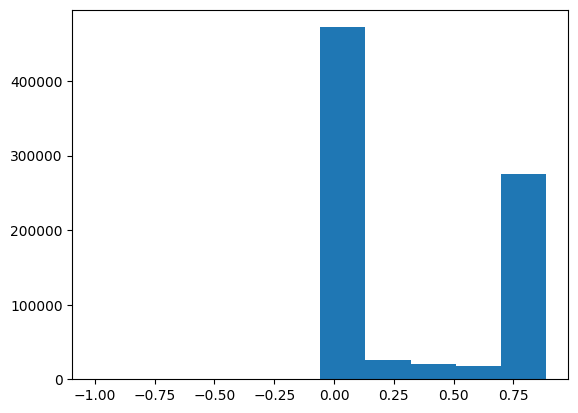

(0.0, 1.0)

In [41]:
plt.hist(df_to_match["SIAMESE_MATCH_SCORE"])
plt.show()
plt.xlim(0,1)


In [39]:
'''
import tensorflow
from keras_preprocessing.sequence import pad_sequences
# loading Siamese model object
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_ind.hdf5")
model_object=tensorflow.keras.models.load_model(model_path,compile=False)

def score_generation(x,y):
    if x=="" or y=="":
        return -1
    else:
        sequences_names_cust=tk.texts_to_sequences([x])
        sequences_names_wl=tk.texts_to_sequences([y])
        cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding='post')
        wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding='post')
        cust_pad_names = np.array(cust_pad_names)
        wl_pad_names = np.array(wl_pad_names)
        return model_object.predict([cust_pad_names,wl_pad_names])[0][0]

df_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].head()

df_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_to_match[["PARTY_NAMES","WL_NAMES"]].apply(lambda x:score_generation(x[0],x[1]),axis=1)
#df_to_match["ALIAS_MATCH_SCORE"]=df_to_match.loc[:,["ALL_ALIAS_NAMES","WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

#df_to_match["FINAL_NAME_MATCH_SCORE"]=df_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)
'''


'\nimport tensorflow\nfrom keras_preprocessing.sequence import pad_sequences\n# loading Siamese model object\nfolder_path =  dataiku.Folder("Name Screening notebooks").get_path()\nmodel_path=os.path.join(folder_path,"mixed_val_loss_ind.hdf5")\nmodel_object=tensorflow.keras.models.load_model(model_path,compile=False)\n\ndef score_generation(x,y):\n    if x=="" or y=="":\n        return -1\n    else:\n        sequences_names_cust=tk.texts_to_sequences([x])\n        sequences_names_wl=tk.texts_to_sequences([y])\n        cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding=\'post\')\n        wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding=\'post\')\n        cust_pad_names = np.array(cust_pad_names)\n        wl_pad_names = np.array(wl_pad_names)\n        return model_object.predict([cust_pad_names,wl_pad_names])[0][0]\n\ndf_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].head()\n\ndf_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_to_match[["PARTY

### Fuzzy logics

In [42]:
'''
from Fuzzy_logics import graph,soundex_encoding,soundex_lev,soundex_dlev,soundex_lcs,soundex_bigram,\
meta_encode,meta_lev,meta_dlev,metaphone_lcs,metaphone_mlipns,metaphone_strcmp95,metaphone_bisim,\
nysiis_encoding,nysiis_lev,mra,nysiis_dlev,nysiis_lcs,nysiis_bisim,\
nysiis_mlipns,nysiis_strcmp95,\
mra_lev,mra_dlev,mra_bisim,\
phonex_encoding,phonex_lev,phonex_dlev,phonex_lcs,phonex_bisim,\
saps_df,lig_df
'''
from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSseq, MLIPNS, Strcmp95,Levenshtein,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, Covington, PhoneticEditDistance,SmithWaterman,LIG3)
import jellyfish
from abydos.phonetic import PSHPSoundexFirst, Ainsworth, Phonex , Metaphone
bisim = BISIM() 
pe = Phonex()
ae=Ainsworth()

In [43]:
# NYSIIS
def nysiis_encoding(df):
    df["PARTY_NAMES_nysiis_encode"]=df["PARTY_NAMES"].apply(lambda x: jellyfish.nysiis(x))
    df["WL_NAMES_nysiis_encode"]=df["WL_NAMES"].apply(lambda x: jellyfish.nysiis(x))
    return df
def nysiis_bisim(df):
    return df[["PARTY_NAMES_nysiis_encode","WL_NAMES_nysiis_encode"]].apply(lambda x: bisim.sim(x[0],x[1]),axis=1).values
df_to_match=nysiis_encoding(df_to_match)

# NYSIIS +  BISIM
df_to_match["Final_Nysiis_bisim_score"]=nysiis_bisim(df_to_match)
df_to_match["Final_Nysiis_bisim_score"]=df_to_match[["Final_Nysiis_bisim_score","PARTY_NAMES","WL_NAMES"]].apply(lambda x: -1 if x[1]=="" or x[2]=="" else x[0],axis=1 )

In [44]:
# Phonex + Bisim
def phonex_encoding(df):
    df["PARTY_NAMES_pe_encode"]=df["PARTY_NAMES"].apply(lambda x: pe.encode(x))
    df["WL_NAMES_pe_encode"]=df["WL_NAMES"].apply(lambda x: pe.encode(x))
    return df
def phonex_bisim(df):
    return df[["PARTY_NAMES_pe_encode","WL_NAMES_pe_encode"]].apply(lambda x: bisim.sim(x[0],x[1]),axis=1).values


df_to_match=phonex_encoding(df_to_match)
df_to_match["Final_Phonex_bisim_score"] = phonex_bisim(df_to_match)


In [45]:
print(df_to_match["Final_Nysiis_bisim_score"].unique())
print(df_to_match["Final_Phonex_bisim_score"].unique())
#print(df_to_match["Final_Ainsworth_bisim_score"].unique())

[ 1.          0.6         0.5         0.70588235  0.54166667  0.57692308
  0.92857143  0.7         0.73809524  0.78        0.47058824  0.71428571
  0.61111111  0.91176471  0.91304348  0.65        0.85294118  0.38888889
  0.71052632  0.59090909  0.85        0.4375      0.75        0.64583333
  0.94736842  0.66666667  0.69047619  0.78947368  0.8         0.5952381
  0.475       0.77777778  0.79166667  0.46428571  0.5625      0.45454545
  0.9375      0.7037037   0.31818182  0.39285714  0.82352941  0.775
  0.875       0.64285714  0.42307692  0.45238095  0.72916667  0.70833333
  0.63636364  0.79411765  0.48        0.46875     0.91666667  0.74
  0.89473684  0.88888889  0.78846154  0.73333333  0.41666667  0.26470588
  0.9         0.4         0.83333333  0.89583333  0.68333333  0.38461538
  0.80769231  0.84        0.7173913   0.61538462  0.86842105  0.54545455
  0.60869565  0.58823529  0.88461538  0.93181818  0.81818182  0.94117647
  0.93333333  0.56666667  0.575       0.68181818  0.8125      0

In [46]:
df_to_match.columns

Index(['ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'V_COMMENTS', 'V_RESOLUTION', 'N_MATCH_SCORE', 'N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'N_WATCHLIST_PROFILE_ID', 'V_PROFILE_NAME', 'NER_ALL_WL_NAMES_FROM_PROFILE', 'WL_NAMES', 'PARTY_NAMES', 'SIAMESE_MATCH_SCORE', 'PARTY_NAMES_nysiis_encode', 'WL_NAMES_nysiis_encode', 'Final_Nysiis_bisim_score', 'PARTY_NAMES_pe_encode', 'WL_NAMES_pe_encode', 'Final_Phonex_bisim_score'], dtype='object')

In [74]:
df_to_match2=df_to_match.copy()
#df_to_match=df_to_match2.copy()


In [75]:
df_to_match=df_to_match[['N_PARTY_WATCHLIST_MATCH_ID','ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES',"PARTY_NAMES","WL_NAMES","SIAMESE_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
#df_to_match[[ 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score']]

In [49]:
#df_to_match[[ 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score']].corr()

## Data Integration

In [0]:
# path_csv=os.path.join(folder_path,"DOB_results.csv")
# df_new_dob=pd.read_csv(path_csv)

In [76]:
df=pd.merge(df_DOB_2,df_id[['N_PARTY_WATCHLIST_MATCH_ID','ID_score','al_wl_ids', 'cust_id_all_sp_accom', 'trans_agg_v_id_type', 'score1']],how="left",on="N_PARTY_WATCHLIST_MATCH_ID")

In [77]:
df=pd.merge(df,df_to_match,how='left',on="N_PARTY_WATCHLIST_MATCH_ID")

In [62]:
df["V_RESOLUTION"]=df["V_RESOLUTION"].apply(lambda x: 1 if x in ["TH","THNM"] else 0)
df.shape

(810460, 149)

In [0]:
df.columns

In [63]:
df_2=df[df["SIAMESE_MATCH_SCORE"]!=-1].copy()

In [171]:
df_2.columns

Index(['N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'V_SCREENING_ID', 'N_WATCHLIST_PROFILE_ID', 'N_MATCH_SCORE', 'V_WATCHLIST_PARTY_NAME', 'V_INFO_SOURCE', 'V_WL_STATUS_CODE', 'D_DT_OF_SCREENING', 'V_COMMENTS',
       ...
       'V_WL_STATUS_CODE_1', 'V_STATUS', 'D_CREATED_DTM_2', 'D_UPDATED_DTM_2', 'V_CATEGORY', 'V_SUB_CATEGORY', 'V_LOCATION_DETAILS', 'V_AGE', 'V_AGE_AS_OF_DATE', 'SANCTIONS'], dtype='object', length=113)

In [175]:
df[["V_CITIZENSHIP","V_DUAL_CITIZENSHIP","V_NATIONALITY","V_GENDER","V_GENDER_WL"]]

,V_CITIZENSHIP,V_DUAL_CITIZENSHIP,V_NATIONALITY,V_GENDER,V_GENDER_WL
443336,BGD,NaN,BANGLADESH,M,M
137254,IDN,NaN,INDONESIA,M,M
404922,CHN,NaN,CHINA,M,M
557051,BGD,NaN,BANGLADESH,M,M
18243,CHN,NaN,CHINA,M,M
...,...,...,...,...,...
598481,MYS,NaN,MALAYSIA,M,M
255670,MYS,NaN,MALAYSIA,M,M
705851,MYS,NaN,MALAYSIA,F,F
524114,MYS,NaN,MALAYSIA,M,M


In [174]:
df.columns[df.columns.str.contains("GENDER")]

Index(['V_GENDER', 'V_GENDER_WL'], dtype='object')

In [0]:
# FH alerts with comments not sounding similiar
df_2["V_COMMENTS"]=df_2["V_COMMENTS"].apply(lambda x: "" if pd.isna(x) else x)
patt_4=re.compile("not sounds similar|not sound similar",re.IGNORECASE)
print("theb FP alerts with comments not sounding similiar",df_2[df_2["V_COMMENTS"].str.contains(patt_4)].shape)
df_sound=df_2[df_2["V_COMMENTS"].str.contains(patt_4)]

plt.hist(df_sound["Final_Nysiis_bisim_score"])
plt.show()

In [0]:
df_s=df_sound[["N_PARTY_WATCHLIST_MATCH_ID","ALL_PARTY_NAMES","ALL_WL_NAMES","PARTY_NAMES","WL_NAMES","ALL_ALIAS_NAMES","V_COMMENTS","SIAMESE_MATCH_SCORE","N_MATCH_SCORE","Final_Nysiis_bisim_score"]]
path_of_not_sounding_simliar=os.path.join(folder_path,"df_sounding_not_similiar.csv")
df_s.to_csv(path_of_not_sounding_simliar)

In [0]:
df_s=df_sound[["N_PARTY_WATCHLIST_MATCH_ID","ALL_PARTY_NAMES","ALL_WL_NAMES","PARTY_NAMES","WL_NAMES","ALL_ALIAS_NAMES","V_COMMENTS","Final_Nysiis_bisim_score"]]
#path_of_not_sounding_simliar=os.path.join(folder_path,"df_sounding_not_similiar.csv")
#df_s.to_csv(path_of_not_sounding_simliar)

## Model Development

In [80]:
df_train=df.copy()
print("shape of train dataset",df_train.shape)

shape of train dataset (810460, 148)


In [66]:
df.columns

Index(['N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'V_SCREENING_ID', 'N_WATCHLIST_PROFILE_ID', 'N_MATCH_SCORE_x', 'V_WATCHLIST_PARTY_NAME', 'V_INFO_SOURCE', 'V_WL_STATUS_CODE', 'D_DT_OF_SCREENING', 'V_COMMENTS',
       ...
       'trans_agg_v_id_type', 'score1', 'ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'PARTY_NAMES', 'WL_NAMES', 'SIAMESE_MATCH_SCORE', 'N_MATCH_SCORE_y', 'Final_Nysiis_bisim_score'], dtype='object', length=149)

In [67]:
df_train[df_train["SIAMESE_MATCH_SCORE"]==-1][["PARTY_NAMES","WL_NAMES"]].shape

(15, 2)

In [81]:
df_train=df_train[df_train["SIAMESE_MATCH_SCORE"]!=-1]

In [82]:
df_train["V_RESOLUTION"].unique()

array(['FP', 'THNM', 'TH'], dtype=object)

In [70]:
val_counts=df_train["V_RESOLUTION"].value_counts()
df_train["V_RESOLUTION"].value_counts()

0    690230
1    120215
Name: V_RESOLUTION, dtype: int64

### Check for imbalance

In [71]:
print("counts of alerts with resolution 0 in train %",df_train["V_RESOLUTION"].value_counts().loc[0]/df_train["V_RESOLUTION"].shape[0])
print("counts of alerts with resolution 1 in train %",df_train["V_RESOLUTION"].value_counts().loc[1]/df_train["V_RESOLUTION"].shape[0])

counts of alerts with resolution 0 in train % 0.8516679108391069
counts of alerts with resolution 1 in train % 0.14833208916089308


 So this is moderately imbalanced , hence no need of doing anything against this imbalancing

### Train-test split

In [18]:
from sklearn.model_selection import train_test_split
X_train=df_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
y_train=df_train["V_RESOLUTION"]

In [20]:
df_train["V_RESOLUTION"].value_counts()

0    690230
1    120215
Name: V_RESOLUTION, dtype: int64

In [87]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()

train_dataset_path_data_enhanced=os.path.join(folder_path,"Final_training_dataset_2_data_enh.csv")
df_train.to_csv(train_dataset_path_data_enhanced) 
#did after including prediction , search for Final_training_dataset_2_data_enh

In [6]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()

train_dataset_path_data_enhanced=os.path.join(folder_path,"Final_training_dataset_2_data_enh.csv")
#df_train=pd.read_csv(train_dataset_path_data_enhanced)
#df_train["V_RESOLUTION"]=df_train["V_RESOLUTION"].apply(lambda x: 1 if x in ["TH","THNM"] else 0)

In [7]:
df_train=pd.read_csv(train_dataset_path_data_enhanced)

In [8]:
df_train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'V_SCREENING_ID', 'N_WATCHLIST_PROFILE_ID', 'N_MATCH_SCORE', 'V_WATCHLIST_PARTY_NAME', 'V_INFO_SOURCE', 'V_WL_STATUS_CODE',
       ...
       'trans_agg_v_id_type', 'score1', 'ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'PARTY_NAMES', 'WL_NAMES', 'SIAMESE_MATCH_SCORE', 'Final_Nysiis_bisim_score', 'V_PREDICTION'], dtype='object', length=151)

In [104]:
df_train["V_RESOLUTION"].value_counts()

0    690230
1    120215
Name: V_RESOLUTION, dtype: int64

In [84]:
df_train[(df_train["FINAL_DOB_MATCH"]== -1) & (df_train["ID_score"]==-1) ][["V_RESOLUTION","V_COMMENTS","Final_Nysiis_bisim_score"]]

,V_RESOLUTION,V_COMMENTS,Final_Nysiis_bisim_score
1,FP,"Mismatch Profile\nAccording to World Check, Watchperson is a Head of Center for Mineral, Coal and Geothermal Resources at Geological Agency of the Ministry of Energy and Mineral Resources (Apr 2022 - ). Meanwhile, customer is an AGRICULTURAL, FORESTRY, FARMING AND FISHERY LABOURERS for SRI WALIS (M) SDN BHD as per UCO. Thus, it is highly unlikely that they are the same person.",1.000000
5,FP,Mismatch Full Legal Name – Name Does Not Sound Similar,0.705882
6,FP,Mismatch Full Legal Name_Name does not sound similar,0.541667
8,FP,"Mismatch Profile. Customer work as Manufacturing Labourer as per UCO meanwhile WL work as Deputy Secretary (Director) to Bangladesh Food Safety Authority as per world check. Hence, It is Highly Unlikely Customer and Watchlist are the same person because of their profile.",1.000000
9,FP,"Mismatch Profile. Customer work as MINING AND CONSTRUCTION LABOURERS as per UCO meanwhile WL work as Deputy Secretary (placed under) to Local Govt Division as per world check. Hence, It is Highly Unlikely Customer and Watchlist are the same person because of their profile.",1.000000
...,...,...,...
810286,TH,NaN,0.673913
810292,THNM,NaN,0.666667
810307,TH,NaN,1.000000
810337,FP,NaN,0.750000


In [85]:
path_of_csv=os.path.join(folder_path,"comments_where_id_dob_absent.csv")
df_train[(df_train["FINAL_DOB_MATCH"]== -1) & (df_train["ID_score"]==-1) & (df_train["Final_Nysiis_bisim_score"]<=0.75) ]["V_COMMENTS"].value_counts().to_csv(path_of_csv)

In [86]:
df_train[(df_train["FINAL_DOB_MATCH"]== -1) & (df_train["ID_score"]==-1) & (df_train["Final_Nysiis_bisim_score"]<=0.75) ].shape

(98937, 148)

In [11]:
X_unseen=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
#df_test["V_RESOLUTION"]=df_test["V_RESOLUTION"].apply(lambda x:1 if x in ["TH","THNM"] else 0)
y_unseen=df_test["V_RESOLUTION"]

In [0]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=9)

In [12]:
df_test["V_RESOLUTION"].value_counts()

0    9216
1     784
Name: V_RESOLUTION, dtype: int64

### Classification model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
#import lightgbm
import catboost
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,f1_score,classification_report,precision_score,recall_score,roc_curve,roc_auc_score

Overall the metric to be checked is f-1 score for target value 1 becoz we need to keep good accuracy on both resolutions.But specifically to analyze how many fp have been reduced we need to see
the precision for target variable 1 (maximizing precision for target var 1 is equivalent to maximzing recall for target value 0).


In [0]:
'''
classifier_SVM = SVC(kernel='rbf',random_state=0)
classifier_SVM.fit(X_train,y_train)
y_predict_train=classifier_SVM.predict(X_train)
y_predict=classifier_SVM.predict(X_test)
y_predict_2=classifier_SVM.predict(X_test_2)
print("results from SVM model, Train data ")
print(classification_report(y_train,y_predict_train))
print("results from SVM model,  Test data")
print(classification_report(y_test,y_predict))
print("results from SVM model, Unseen data")
print(classification_report(y_test_2,y_predict_2))
score=cross_val_score(classifier_SVM,X_train,y_train,cv=5,scoring='f1_macro')
print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
results["SVM"]=f1_score(y_test_2,y_predict_2)
'''

### Model function

In [113]:
results={}


for model_name in ["LG","Random forest","LightGBM","XG Boost"]:
    if model_name=="LG":
        classifier_lg=LogisticRegression(class_weight="balanced",random_state=0)
        classifier_lg.fit(X_train,y_train)
        y_predict_train=classifier_lg.predict(X_train)
       # y_predict=classifier_lg.predict(X_test)
        y_predict_2=classifier_lg.predict(X_unseen)
        print("results from Logistic Regression model on train data")
        print(classification_report(y_train,y_predict_train))
       # print("results from Logistic Regression model on test data")
       # print(classification_report(y_train,y_predict_train))
        print("results from Logistic Regression model on Unseen data")
        print(classification_report(y_unseen,y_predict_2))
     #   score=cross_val_score(classifier_lg,X_train,y_train,cv=5,scoring='f1')
     #   print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
     #   results["LG"]=f1_score(y_unseen,y_predict_2)   
#     if model_name=="LightGBM":
#         classifier_lgbm=LGBMClassifier(random_state=1,verbose_eval=False)
#         classifier_lgbm.fit(X_train,y_train)
#         y_predict_train=classifier_lgbm.predict(X_train)
#        # y_predict=classifier_lgbm.predict(X_test)
#         y_predict_2=classifier_lgbm.predict(X_unseen)
#         print("results from LightGBM model, Train data ")
#         print(classification_report(y_train,y_predict_train))
#     #    print("results from LightGBM model,  Test data")
#     #    print(classification_report(y_test,y_predict))
#         print("results from LightGBM model, Unseen data")
#         print(classification_report(y_unseen,y_predict_2))
#    #      score=cross_val_score(classifier_lgbm,X_train,y_train,cv=5,scoring='f1')
#    #     print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
#    #     results["LightGBM"]=f1_score(y_unseen,y_predict_2)        
    elif model_name =="Random forest":
        # Random forest 

        classifier_RF=RandomForestClassifier(max_features=None,random_state=0)
        classifier_RF.fit(X_train, y_train)
        y_predict_train=classifier_RF.predict(X_train)
        #y_predict=classifier_RF.predict(X_test)
        y_predict_2=classifier_RF.predict(X_unseen)
        print("results from RF model, Train data ")
        print(classification_report(y_train,y_predict_train))
   #     print("results from RF model,  Test data")
   #     print(classification_report(y_test,y_predict))
        print("results from RF model, Unseen data")
        print(classification_report(y_unseen,y_predict_2))
   #     score=cross_val_score(classifier_RF,X_train,y_train,cv=5,scoring='f1_macro')
   #     print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
   #     results["RF"]=f1_score(y_unseen,y_predict_2)
       
    # XGBoost
    elif model_name=="XG Boost":
        classifier_XGB = xgb.XGBClassifier(random_state=0)
        classifier_XGB.fit(X_train, y_train)
        y_predict_train=classifier_XGB.predict(X_train)
        #y_predict=classifier_XGB.predict(X_test)
        y_predict_2=classifier_XGB.predict(X_unseen)
        print("Results from XGBoost model, Train data ")
        print(classification_report(y_train,y_predict_train))
  #      print("results from XG Boost model,  Test data")
  #      print(classification_report(y_test,y_predict))
        print("results from XG Boost model, Unseen data")
        print(classification_report(y_unseen,y_predict_2))
  #     score=cross_val_score(classifier_XGB,X_train,y_train,cv=5,scoring='f1')
  #      print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())        
  #      results["XGBoost"]=f1_score(y_unseen,y_predict_2)
        



results from Logistic Regression model on train data
              precision    recall  f1-score   support

           0       0.98      0.88      0.93    690230
           1       0.57      0.88      0.69    120215

    accuracy                           0.88    810445
   macro avg       0.77      0.88      0.81    810445
weighted avg       0.92      0.88      0.89    810445

results from Logistic Regression model on Unseen data
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      9216
           1       0.38      0.58      0.46       784

    accuracy                           0.89     10000
   macro avg       0.67      0.75      0.70     10000
weighted avg       0.92      0.89      0.90     10000

results from RF model, Train data 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    690230
           1       0.99      0.91      0.95    120215

    accuracy                           0

In [0]:
X_train

In [0]:
'''
# LightGBM
predicted_proba=classifier_lgbm.predict_proba(X_train)
FPR, TPR, proba = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["LightGBM"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print(classification_report(y_test,roc_predictions))
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".")
plt.title("LightGBM ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Adaboost
predicted_proba=classifier_ada.predict_proba(X_train)
FPR, TPR, proba = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["Adaboost"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print(classification_report(y_test,roc_predictions))
predicted_proba=classifier_ada.predict_proba(X_train)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".")
plt.title("Adaboost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()



#CatBoost 
predicted_proba=classifier_cat.predict_proba(X_train)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["CatBoost"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print(classification_report(y_test,roc_predictions))


plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".")
plt.title("CatBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()
'''

In [106]:
#Nueral Networks
import tensorflow as tf

In [114]:
X_train.info()
y_train=df_train["V_RESOLUTION"].astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810445 entries, 0 to 810444
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   FINAL_DOB_MATCH           810445 non-null  float64
 1   ID_score                  810445 non-null  float64
 2   SIAMESE_MATCH_SCORE       810445 non-null  float64
 3   N_MATCH_SCORE             810445 non-null  float64
 4   Final_Nysiis_bisim_score  810445 non-null  float64
dtypes: float64(5)
memory usage: 30.9 MB


In [115]:
X_2,X_val,y_2,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [116]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
folder_path=dataiku.Folder("Name Screening notebooks").get_path()

In [117]:
ann=tf.keras.models.Sequential()
# hidden layers-2 with 6 neurons
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))

# output layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# compile
ann.compile( optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.F1Score(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

keras_callbacks   = [\
      EarlyStopping(monitor='val_loss', min_delta =0.01, patience=25, mode='min'),\
      ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=10, min_lr=0.000001),\
      ModelCheckpoint(filepath=os.path.join(folder_path,"nn_challenger_model.hdf5"),
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True,
                      save_weights_only=False,
                      mode='min',
                      )]

ann.fit(X_2,y_2,batch_size=30,epochs=10,class_weight={0:0.4,1:0.6},validation_data=(X_val,y_val))


Epoch 1/10
21612/21612 [==============================] - 138s 6ms/step - loss: 0.1015 - f1_score: 0.2581 - precision: 0.9854 - recall: 0.8297 - val_loss: 0.1679 - val_f1_score: 0.2588 - val_precision: 0.9921 - val_recall: 0.8578
Epoch 2/10
21612/21612 [==============================] - 45s 2ms/step - loss: 0.0875 - f1_score: 0.2582 - precision: 0.9825 - recall: 0.8558 - val_loss: 0.1578 - val_f1_score: 0.2588 - val_precision: 0.9928 - val_recall: 0.8561
Epoch 3/10
21612/21612 [==============================] - 47s 2ms/step - loss: 0.0855 - f1_score: 0.2582 - precision: 0.9831 - recall: 0.8558 - val_loss: 0.1563 - val_f1_score: 0.2588 - val_precision: 0.9924 - val_recall: 0.8564
Epoch 4/10
21612/21612 [==============================] - 51s 2ms/step - loss: 0.0528 - f1_score: 0.2582 - precision: 0.9920 - recall: 0.8576 - val_loss: 0.0946 - val_f1_score: 0.2588 - val_precision: 0.9904 - val_recall: 0.8737
Epoch 5/10
21612/21612 [==============================] - 51s 2ms/step - loss: 0.04

In [118]:
print("Classification report on train dataset  using NN")
y_predict_train=[1 if i>0.5 else 0 for i in ann.predict(X_train)]
print(classification_report(y_train,y_predict_train))
print("Classification report on test dataset using NN")
y_predict=[1 if i>0.5 else 0 for i in ann.predict(X_unseen)]
print(classification_report(y_unseen,y_predict))

Classification report on train dataset  using NN
25327/25327 [==============================] - 41s 2ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    690230
         1.0       0.99      0.87      0.93    120215

    accuracy                           0.98    810445
   macro avg       0.98      0.93      0.96    810445
weighted avg       0.98      0.98      0.98    810445

Classification report on test dataset using NN
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9216
           1       0.98      0.57      0.72       784

    accuracy                           0.97     10000
   macro avg       0.97      0.79      0.85     10000
weighted avg       0.97      0.97      0.96     10000



In [119]:
# how to overcome overfitting -  addition of drop-out layer, weights & parameter regularizer -  keras_regualrizer
# Bayesian optimization

import keras_tuner

def build_model(hp):
    ann_2=tf.keras.models.Sequential()
    # hidden layers-2 with 6 neurons
    unit_val=hp.Choice("units",values=[4,5,6])
    ann_2.add(tf.keras.layers.Dense(units=unit_val,activation="relu",kernel_regularizer='l1_l2'))
    ann_2.add(tf.keras.layers.Dense(units=unit_val,activation="relu"))
    ann_2.add(tf.keras.layers.Dropout(0.2))
    # output layer
    ann_2.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    learning_rate_val=hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])
    # compile
    ann_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate_val),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.F1Score(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return ann_2


In [120]:
X_2,X_val,y_2,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [125]:
tuner=keras_tuner.BayesianOptimization(build_model,objective='val_loss',max_trials=5)
tuner.search(X_2,y_2,epochs=5,validation_data=(X_val,y_val))


Reloading Tuner from ./untitled_project/tuner0.json


In [126]:
model=build_model(tuner.get_best_hyperparameters()[0])
history=model.fit(X_2,y_2,callbacks=keras_callbacks,class_weight={0:0.4,1:0.6},validation_data=(X_val,y_val),epochs=10,batch_size=32)

Epoch 1/10
20254/20262 [============================>.] - ETA: 0s - loss: 0.2361 - f1_score: 0.2582 - precision_2: 0.7207 - recall_2: 0.6387
Epoch 1: val_loss did not improve from 0.10745
20262/20262 [==============================] - 116s 6ms/step - loss: 0.2360 - f1_score: 0.2582 - precision_2: 0.7208 - recall_2: 0.6387 - val_loss: 0.2190 - val_f1_score: 0.2588 - val_precision_2: 0.9921 - val_recall_2: 0.8576 - lr: 1.0000e-04
Epoch 2/10
20255/20262 [============================>.] - ETA: 0s - loss: 0.1340 - f1_score: 0.2582 - precision_2: 0.9919 - recall_2: 0.6827
Epoch 2: val_loss did not improve from 0.10745
20262/20262 [==============================] - 116s 6ms/step - loss: 0.1340 - f1_score: 0.2582 - precision_2: 0.9919 - recall_2: 0.6827 - val_loss: 0.1797 - val_f1_score: 0.2588 - val_precision_2: 0.9918 - val_recall_2: 0.8585 - lr: 1.0000e-04
Epoch 3/10
20245/20262 [============================>.] - ETA: 0s - loss: 0.1187 - f1_score: 0.2582 - precision_2: 0.9922 - recall_2: 0.

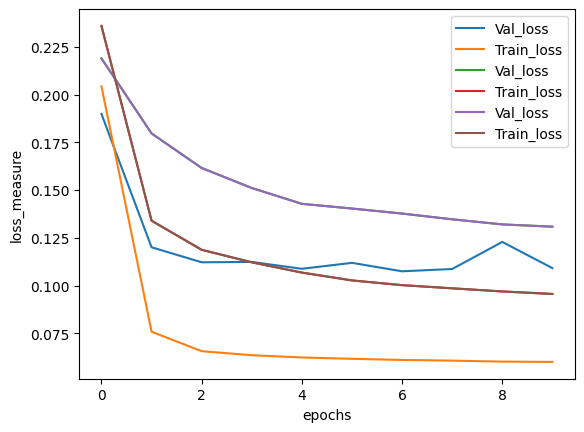

In [129]:
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt 
history.params
history.history.keys()
plt.plot(history.history["val_loss"],label="Val_loss")
plt.plot(history.history["loss"],label="Train_loss")
plt.xlabel("epochs")
plt.ylabel("loss_measure")
plt.legend()
plt.show()

In [133]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
model_path_2=os.path.join(folder_path,"nn_challenger_model.hdf5")
model=tf.keras.models.load_model(model_path_2,compile=False)

In [134]:

print("Classification report on train dataset  using NN")
y_predict_train=[1 if i>0.5 else 0 for i in model.predict(X_train)]
print(classification_report(y_train,y_predict_train))
print("Classification report on test dataset using NN")
y_predict=[1 if i>0.5 else 0 for i in model.predict(X_unseen)]
print(classification_report(y_unseen,y_predict))

Classification report on train dataset  using NN
25327/25327 [==============================] - 29s 1ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    690230
         1.0       0.99      0.87      0.93    120215

    accuracy                           0.98    810445
   macro avg       0.98      0.94      0.96    810445
weighted avg       0.98      0.98      0.98    810445

Classification report on test dataset using NN
313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9216
           1       0.99      0.57      0.72       784

    accuracy                           0.97     10000
   macro avg       0.98      0.79      0.85     10000
weighted avg       0.97      0.97      0.96     10000



20262/20262 [==============================] - 23s 1ms/step
opt_thresh_prob 0.208438


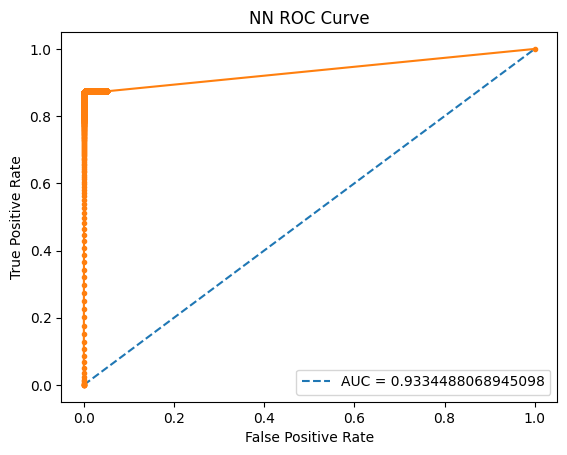

In [135]:
# ROC curve on neural network
from sklearn.metrics import roc_curve
y_pred_nn=model.predict(X_2)
FPR,TPR,thresh=roc_curve(y_2,y_pred_nn)
optimal_proba_cutoff_nn=sorted(list(zip(np.abs(TPR-FPR),thresh)),key=lambda i: i[0],reverse=True)[0][1]
print("opt_thresh_prob",optimal_proba_cutoff_nn)

#print(classification_report(y_test,roc_predictions))
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_2, y_pred_nn)}") # plot random curve

plt.plot(FPR, TPR, marker=".")
plt.title("NN ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [136]:
# Results from NN after tuning & using optimal threshold on unseen data - will discard it from choosing a champion model
y_unseen_pred=[1 if i>optimal_proba_cutoff_nn else 0 for i in model.predict(X_unseen)]
print(classification_report(y_unseen,y_unseen_pred))
y_pred_train=[1 if i>optimal_proba_cutoff_nn else 0 for i in model.predict(X_train)]
print(classification_report(y_train,y_pred_train))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9216
           1       0.98      0.57      0.72       784

    accuracy                           0.97     10000
   macro avg       0.97      0.79      0.85     10000
weighted avg       0.97      0.97      0.96     10000

25327/25327 [==============================] - 25s 997us/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    690230
         1.0       0.99      0.87      0.93    120215

    accuracy                           0.98    810445
   macro avg       0.98      0.94      0.96    810445
weighted avg       0.98      0.98      0.98    810445



### Hyperparameter tuning

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [15]:
from sklearn.model_selection import GridSearchCV

In [139]:
#Logistic Regression
classifier_lg=LogisticRegression(random_state=0)
print(classifier_lg.get_params())
params=[{"solver":["lbfgs", "liblinear", "newton-c  g"],"class_weight":["balanced",{0:0.4,1:0.6}],"penalty":["l1","l2","elasticnet"]}]

cv_grid_lg=GridSearchCV(classifier_lg,param_grid=params,scoring="f1",cv=10,n_jobs=-1)
cv_grid_lg.fit(X_train,y_train)


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', {0: 0.4, 1: 0.6}],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['lbfgs', 'liblinear', 'newton-c  g']}],
             scoring='f1')

In [140]:
# Randaom Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#'criterion':['gini','entropy']
#"max_depth":[4,5,6],"class_weight":["balanced",{0:0.40,1:0.6}]
classifier_RF=RandomForestClassifier()
print(classifier_RF.get_params())
params=[{"n_estimators":[100,200],"min_samples_split":[3,4,5],"max_features":[None]}]
cv_grid_rf=GridSearchCV(classifier_RF,param_grid=params,scoring="f1",n_jobs=-1,cv=5)
cv_grid_rf.fit(X_train,y_train)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [None],
                          'min_samples_split': [3, 4, 5],
                          'n_estimators': [100, 200]}],
             scoring='f1')

In [16]:
# XGboost
from xgboost import XGBClassifier
classifier_XGB=XGBClassifier()
params=[{"n_estimators":[50,75,100],"max_depth":[3,4,5,6],"learning_rate":[0.001,0.01,0.1],'reg_alpha':[1,5,10],'reg_lambda':[0,5,10],"class_weight":["balanced",{0:0.4,1:0.6}]}]
cv_grid_xgb=GridSearchCV(classifier_XGB,param_grid=params,scoring="f1",cv=10,n_jobs=-1)


In [21]:
cv_grid_xgb.fit(X_train,y_train)
print(cv_grid_xgb.best_score_,cv_grid_xgb.best_params_)

0.9258397848768848 {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 75, 'reg_alpha': 1, 'reg_lambda': 10}


In [144]:
# # Light GBM
# from sklearn.model_selection import GridSearchCV

# from lightgbm import LGBMClassifier

# # '''
# classifier_lgbm=LGBMClassifier()
# #,"learning_rate":[0.1,0.001,0.005]
# #"reg_alpha":[0,1,5],"reg_lambda":[1,5]
# params=[{"boosting_type":["goss"], "n_estimators":[50,75,100],"max_depth":[4,5,6],\
# "class_weight":["balanced",{1:0.6,0:0.4}]}]
# cv_grid_lgbm=GridSearchCV(classifier_lgbm,param_grid=params,scoring="f1",n_jobs=-1,cv=10)
# cv_grid_lgbm.fit(X_train,y_train)
# print(cv_grid_lgbm.best_score_,cv_grid_lgbm.best_params_)


### Re-training

In [145]:
cv_grid_lg.best_params_

{'class_weight': {0: 0.4, 1: 0.6}, 'penalty': 'l2', 'solver': 'liblinear'}

In [146]:
# Logistic
print(list(cv_grid_lg.best_params_.values()))
classifier_lg=LogisticRegression(**cv_grid_lg.best_params_)
classifier_lg.fit(X_train,y_train)

[{0: 0.4, 1: 0.6}, 'l2', 'liblinear']


LogisticRegression(class_weight={0: 0.4, 1: 0.6}, solver='liblinear')

In [147]:
classifier_lg.predict(X_unseen)
y_unseen

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: V_RESOLUTION, Length: 10000, dtype: int64

In [148]:
from sklearn.metrics import classification_report
print(classification_report(y_train,classifier_lg.predict(X_train)))
print(classification_report(y_unseen,classifier_lg.predict(X_unseen)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    690230
         1.0       0.99      0.86      0.92    120215

    accuracy                           0.98    810445
   macro avg       0.98      0.93      0.95    810445
weighted avg       0.98      0.98      0.98    810445

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9216
           1       1.00      0.57      0.72       784

    accuracy                           0.97     10000
   macro avg       0.98      0.78      0.85     10000
weighted avg       0.97      0.97      0.96     10000



In [149]:
# Saving_model object LG
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Logistic_model_tuned_data_enh.sav')
pickle.dump(classifier_lg, open(file_path, 'wb'))
 

In [150]:
# Random forest
classifier_RF=RandomForestClassifier(**cv_grid_rf.best_params_)
classifier_RF.fit(X_train,y_train)

RandomForestClassifier(max_features=None, min_samples_split=5, n_estimators=200)

In [151]:
print(classification_report(y_train,classifier_RF.predict(X_train)))
print(classification_report(y_unseen,classifier_RF.predict(X_unseen)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    690230
         1.0       0.99      0.91      0.95    120215

    accuracy                           0.99    810445
   macro avg       0.99      0.95      0.97    810445
weighted avg       0.99      0.99      0.98    810445

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9216
           1       0.78      0.61      0.68       784

    accuracy                           0.96     10000
   macro avg       0.88      0.80      0.83     10000
weighted avg       0.95      0.96      0.95     10000



In [152]:
# Saving_model object RF
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Random_forest_tuned_data_enh.sav')
pickle.dump(classifier_RF, open(file_path, 'wb'))

In [22]:
# XGBoost
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)
re_xgb.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, ...)

In [154]:
print(classification_report(y_train,re_xgb.predict(X_train)))
print(classification_report(y_unseen,re_xgb.predict(X_unseen)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    690230
         1.0       0.99      0.88      0.93    120215

    accuracy                           0.98    810445
   macro avg       0.99      0.94      0.96    810445
weighted avg       0.98      0.98      0.98    810445

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9216
           1       0.99      0.58      0.73       784

    accuracy                           0.97     10000
   macro avg       0.98      0.79      0.86     10000
weighted avg       0.97      0.97      0.96     10000



In [23]:
# Saving_model object XGB
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Classifier_xgb_tuned_data_enh_with_names.sav')
pickle.dump(re_xgb, open(file_path, 'wb'))

In [156]:
# #lightgbm
# classifier_lgbm=LGBMClassifier(random_state=1,verbose_eval=False)
# classifier_lgbm.fit(X_train,y_train)
'''
classifier_lgbm=LGBMClassifier(**cv_grid_lgbm.best_params_)
classifier_lgbm.fit(X_train,y_train)
'''

'\nclassifier_lgbm=LGBMClassifier(**cv_grid_lgbm.best_params_)\nclassifier_lgbm.fit(X_train,y_train)\n'

In [157]:
# print(classification_report(y_train,classifier_lgbm.predict(X_train)))
# print(classification_report(y_unseen,classifier_lgbm.predict(X_unseen)))

NameError: name 'classifier_lgbm' is not defined

In [0]:
# # Saving_model object LGBM
# folder_path=dataiku.Folder("Name Screening notebooks").get_path()
# file_path = os.path.join(folder_path,'Light_GBM_tuned_data_enh.sav')
# pickle.dump(classifier_lgbm, open(file_path, 'wb'))

### Prediction on Train

In [158]:
# model prediction
df_train["V_PREDICTION"]=re_xgb.predict(X_train)

In [159]:
# train_dataset_path_2=os.path.join(folder_path,"Final_training_dataset_2_data_enh.csv")
# df_train.to_csv(train_dataset_path_2)

In [160]:
df_train.shape

(810445, 150)

### ROC curve

LG threshold : 0.42914281058009845


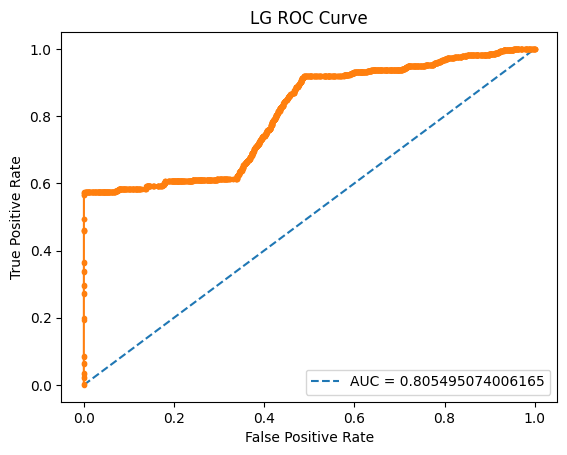

RF threshold : 0.045629019496306863


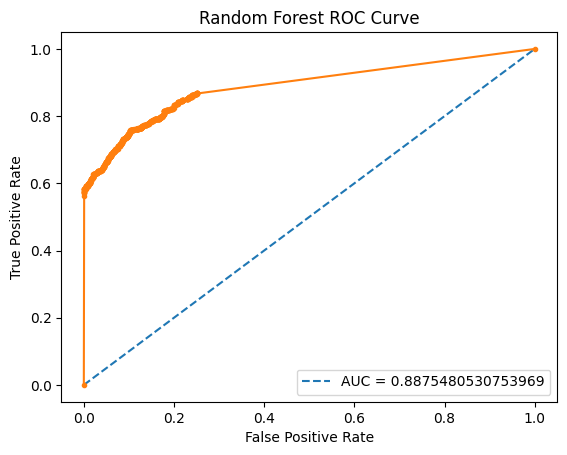

XG Boost threshold : 0.3562965853081103


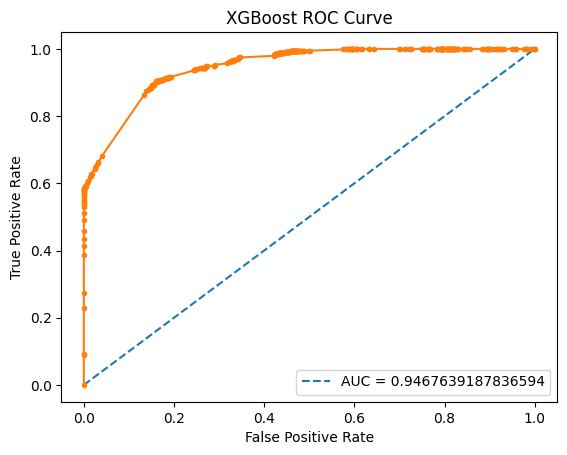

In [162]:
thresh_dict={}
# Logistic Regression
predicted_proba=classifier_lg.predict_proba(X_unseen)
FPR, TPR, proba = roc_curve(y_unseen, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["LG"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lg.predict_proba(X_unseen)[:, -1]]
print("LG threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_unseen, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("LG ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()


#Random forest
predicted_proba=classifier_RF.predict_proba(X_unseen)
FPR, TPR, thres = roc_curve(y_unseen, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["Random forest"]=optimal_proba_cutoff

print("RF threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_unseen, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("Random Forest ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()
# # LightGBM
# predicted_proba=classifier_lgbm.predict_proba(X_unseen)
# FPR, TPR, proba = roc_curve(y_unseen, predicted_proba[:, -1])
# optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
# thresh_dict["LightGBM"]=optimal_proba_cutoff
# print("Light GBM :", optimal_proba_cutoff)
# plt.figure()
# plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_unseen, predicted_proba[:, -1])}") # plot random curve
# plt.plot(FPR,TPR, marker=".")
# plt.title("LightGBM ROC Curve")
# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.legend(loc="lower right")
# plt.show()

#XG Boost
predicted_proba=re_xgb.predict_proba(X_unseen)
FPR, TPR, thres = roc_curve(y_unseen, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["XG Boost"]=optimal_proba_cutoff
print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_unseen, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()




### PRC curve

LG threshold : 0.8977880042503309


<Figure size 640x480 with 0 Axes>

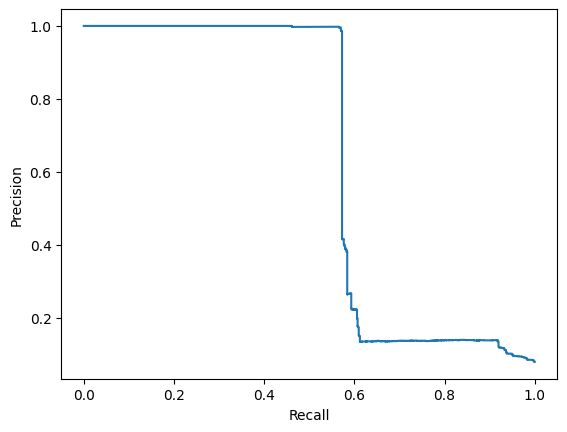

RF threshold : 0.0
XGB threshold : 0.00048615018


<Figure size 640x480 with 0 Axes>

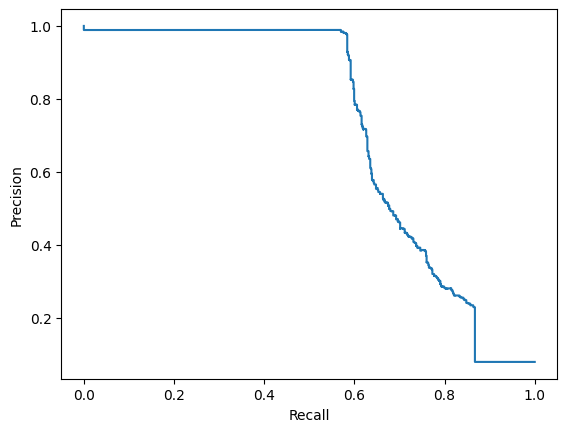

<Figure size 640x480 with 0 Axes>

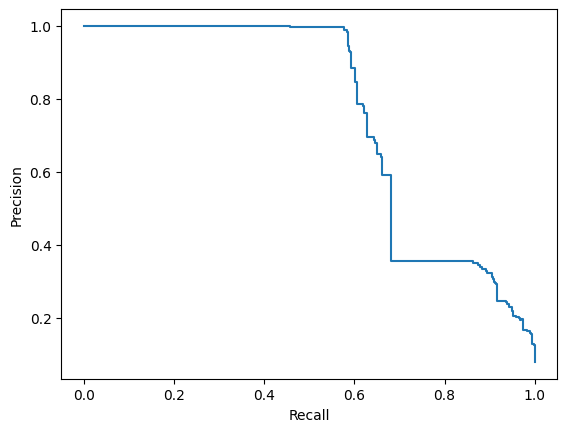

In [163]:
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay
import matplotlib.pyplot as plt
thres_dict_prc ={} 

# Logistic Regression
Pre,Rec,th=precision_recall_curve(y_unseen,probas_pred=classifier_lg.predict_proba(X_unseen)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec),th)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["LG"]=optimal_proba_cutoff
print("LG threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
#plt.plot(Pre, Rec, marker=".")
#plt.title("LG ROC Curve")
#plt.ylabel("True Positive Rate")
#plt.xlabel("False Positive Rate")
#plt.legend(loc="lower right")
#plt.show()
plt.show()


# Random Forest
Pre,Rec,th=precision_recall_curve(y_unseen,classifier_RF.predict_proba(X_unseen)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec), th)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["RF"]=optimal_proba_cutoff
print("RF threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
#plt.plot(Pre, Rec, marker=".")



# XGBoost
Pre,Rec,th=precision_recall_curve(y_unseen,probas_pred=re_xgb.predict_proba(X_unseen)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec),th)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["XGB"]=optimal_proba_cutoff
print("XGB threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
#plt.plot(Pre, Rec, marker=".")
plt.show()




# # LightGBM
# Pre,Rec,th=precision_recall_curve(y_unseen,probas_pred=classifier_lgbm.predict_proba(X_unseen)[:,-1])
# optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec),th)), key=lambda i: i[0], reverse=True)[0][1]
# thres_dict_prc["LGBM"]=optimal_proba_cutoff
# print("LGBM threshold :", optimal_proba_cutoff)
# plt.figure()
# disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
# disp.plot()
# #plt.plot(Pre, Rec, marker=".")
# plt.show()


In [0]:
class model_prob_data_enh:
    def __init__(self):
        self.dict=thresh_dict
prob=model_prob_data_enh()
file_path=os.path.join(folder_path,"opt_thres_data_enh.sav")
pickle.dump(prob,open(file_path,"wb"))
x=pickle.load(open(file_path,"rb"))

In [166]:
x.dict

{'LG': 0.42914281058009845,
 'Random forest': 0.045629019496306863,
 'XG Boost': 0.3562965853081103}

# CHAMPION MODEL SELECTION

In [167]:


print("LG")
y_unseen_pred=[1 if i> thresh_dict["LG"] else 0 for i in  classifier_lg.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["LG"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]

print(classification_report(y_unseen,y_unseen_pred))
print("RF")
y_unseen_pred=[1 if i> thresh_dict["Random forest"] else 0 for i in  classifier_RF.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["Random forest"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]


print(classification_report(y_unseen,y_unseen_pred))
# print("LGBM")
# y_unseen_pred=[1 if i> thresh_dict["LightGBM"] else 0 for i in  classifier_lgbm.predict_proba(X_unseen)[:, 1] ]
# y_train_pred=[1 if i> thresh_dict["LightGBM"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]


# print(classification_report(y_unseen,y_unseen_pred))
print("XGB")
y_unseen_pred=[1 if i> thresh_dict["XG Boost"] else 0 for i in  re_xgb.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["XG Boost"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]

print(classification_report(y_unseen,y_unseen_pred))




LG
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9216
           1       0.99      0.57      0.72       784

    accuracy                           0.97     10000
   macro avg       0.98      0.79      0.85     10000
weighted avg       0.97      0.97      0.96     10000

RF
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      9216
           1       0.32      0.78      0.45       784

    accuracy                           0.85     10000
   macro avg       0.65      0.82      0.68     10000
weighted avg       0.93      0.85      0.88     10000

XGB
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9216
           1       0.99      0.58      0.73       784

    accuracy                           0.97     10000
   macro avg       0.98      0.79      0.86     10000
weighted avg       0.97      0.97      0.96     10000



In [24]:
# save the model to disk
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'finalized_model_(siamese & fuzzy(only_orginal_name)_data_enh_with_names.sav')
pickle.dump(re_xgb, open(file_path, 'wb'))
 



In [0]:
X_train.columns

In [33]:
# October 
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
Unseen_proc_data_path=os.path.join(folder_path,"Unseen_processed_data_enhanced_oct_100_anj_rev.csv")

df_test_oct=pd.read_csv(Unseen_proc_data_path)
X_test=df_test_oct[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
y_test=df_test_oct["V_RESOLUTION"]

In [34]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'finalized_model_(siamese & fuzzy(only_orginal_name)_data_enh.sav')

# load the model from disk
champ_model = pickle.load(open(file_path, 'rb'))

In [35]:

class model_prob_data_enh:
    def __init__(self):
        self.dict=thresh_dict
#prob=model_prob_data_enh()
file_path=os.path.join(folder_path,"opt_thres_data_enh.sav")
opt=pickle.load(open(file_path,"rb"))
thresh_dict=opt.dict

In [36]:
thresh_dict["XG Boost"]

0.3562965853081103

XGB threshold : 0.00027704873


<Figure size 640x480 with 0 Axes>

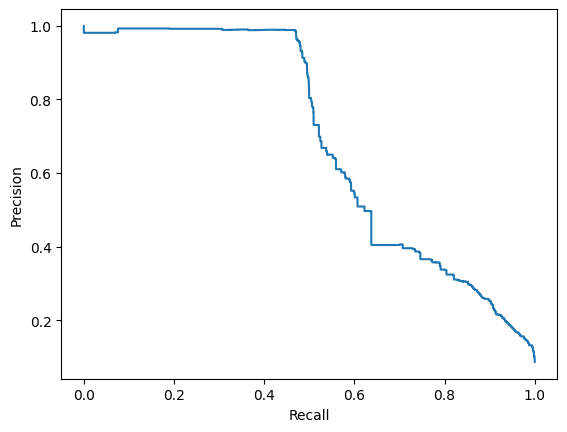

In [37]:
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay
import matplotlib.pyplot as plt
thres_dict_prc_2 ={} 

# # Logistic Regression
# Pre,Rec,th=precision_recall_curve(y_unseen,probas_pred=classifier_lg.predict_proba(X_test)[:,-1])
# optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec),th)), key=lambda i: i[0], reverse=True)[0][1]
# thres_dict_prc_2["LG"]=optimal_proba_cutoff
# print("LG threshold :", optimal_proba_cutoff)
# plt.figure()
# disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
# disp.plot()
# #plt.plot(Pre, Rec, marker=".")
# #plt.title("LG ROC Curve")
# #plt.ylabel("True Positive Rate")
# #plt.xlabel("False Positive Rate")
# #plt.legend(loc="lower right")
# #plt.show()
# plt.show()


# # Random Forest
# Pre,Rec,th=precision_recall_curve(y_unseen,classifier_RF.predict_proba(X_test)[:,-1])
# optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec), th)), key=lambda i: i[0], reverse=True)[0][1]
# thres_dict_prc_2["RF"]=optimal_proba_cutoff
# print("RF threshold :", optimal_proba_cutoff)
# plt.figure()
# disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
# disp.plot()
# #plt.plot(Pre, Rec, marker=".")



# XGBoost
Pre,Rec,th=precision_recall_curve(y_test,probas_pred=champ_model.predict_proba(X_test)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec),th)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc_2["XGB"]=optimal_proba_cutoff
print("XGB threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
#plt.plot(Pre, Rec, marker=".")
plt.show()




# # LightGBM
# Pre,Rec,th=precision_recall_curve(y_unseen,probas_pred=classifier_lgbm.predict_proba(X_test)[:,-1])
# optimal_proba_cutoff = sorted(list(zip(np.abs(Pre - Rec),th)), key=lambda i: i[0], reverse=True)[0][1]
# thres_dict_prc["LGBM"]=optimal_proba_cutoff
# print("LGBM threshold :", optimal_proba_cutoff)
# plt.figure()
# disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
# disp.plot()
# #plt.plot(Pre, Rec, marker=".")
# plt.show()


In [55]:
# from sklearn.metrics import classification_report
y_unseen_pred=[1 if i> 0.11904873 else 0 for i in  champ_model.predict_proba(X_test)[:, 1] ]
print(classification_report(y_test,y_unseen_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     47360
           1       0.80      0.50      0.62      4483

    accuracy                           0.95     51843
   macro avg       0.88      0.75      0.80     51843
weighted avg       0.94      0.95      0.94     51843



In [20]:
# November 



folder_path=dataiku.Folder("Name Screening notebooks").get_path()
Unseen_proc_data_path_1=os.path.join(folder_path,"Unseen_processed_data_enhanced_nov_100_edit_0124.csv")
df_test_nov=pd.read_csv(Unseen_proc_data_path_1)
X_test=df_test_nov[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
y_test=df_test_nov["V_RESOLUTION"]

In [21]:
y_unseen_pred=[1 if i> thresh_dict["XG Boost"] else 0 for i in  champ_model.predict_proba(X_test)[:, 1] ]
print(classification_report(y_test,y_unseen_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     52751
           1       0.99      0.75      0.86      5505

    accuracy                           0.98     58256
   macro avg       0.98      0.88      0.92     58256
weighted avg       0.98      0.98      0.97     58256



In [192]:
# December 10 K
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
Unseen_proc_data_path=os.path.join(folder_path,"Unseen_processed_data_enhanced_dec_10k.csv")
df_test_dec=pd.read_csv(Unseen_proc_data_path)
#pd.read_csv(Unseen_proc_data_path)

X_test=df_test_dec[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
y_test=df_test_dec["V_RESOLUTION"]

In [193]:
y_unseen_pred=[1 if i> thresh_dict["XG Boost"] else 0 for i in  re_xgb.predict_proba(X_test)[:, 1] ]
print(classification_report(y_test,y_unseen_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9599
           1       0.92      0.18      0.30       401

    accuracy                           0.97     10000
   macro avg       0.95      0.59      0.64     10000
weighted avg       0.97      0.97      0.96     10000



# Feature Importance

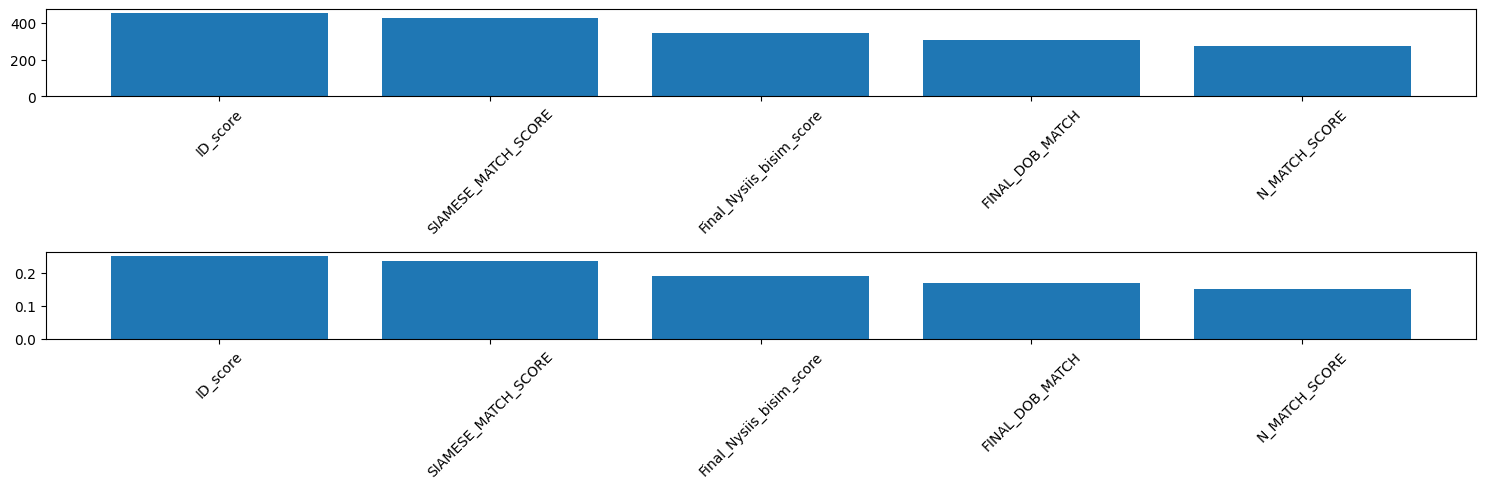

In [169]:
X_4=X_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score']]
y_4=df_train[["V_RESOLUTION"]]
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)





re_xgb.fit(X_4,y_4)

fi_4 = pd.DataFrame({'Feature_names':X_4.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})
fi_4["Percent_Weight_Imp"]=[i/ sum(fi_4["Weight_Imp"].values) for i in fi_4["Weight_Imp"]]
fi_4.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi_4["Feature_names"],fi_4["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.sca(ax[1])
ax[1].bar(fi_4["Feature_names"],fi_4["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()


In [170]:
fi_4[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

,Feature_names,Weight_Imp,Percent_Weight_Imp
1,ID_score,452.0,0.251390
2,SIAMESE_MATCH_SCORE,425.0,0.236374
4,Final_Nysiis_bisim_score,344.0,0.191324
0,FINAL_DOB_MATCH,305.0,0.169633
3,N_MATCH_SCORE,272.0,0.151279


# Feature Attribution

In [0]:
DOR : Used Lime for feature attribution on test data where we get feature and respective scores contributing in resolution.
    Removed the features whoose scores are negative & those features if dat for them is absent in V_REASON columns

In [0]:
model_path=os.path.join(folder_path,"Classifier_xgb_tuned.sav")
re_xgb=pickle.load(open(model_path,"rb"))

In [0]:
import lime
import lime.lime_tabular
import sklearn
from __future__ import print_function
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

In [0]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns, class_names=y_train.unique(), discretize_continuous=False)

In [0]:
import numpy as np

exp = explainer.explain_instance(X_unseen.loc[0], re_xgb.predict_proba,num_features=5,  top_labels=2)

In [0]:
exp.show_in_notebook()

In [0]:
exp.as_pyplot_figure(label=1)

In [0]:
exp.as_map()

In [0]:
exp.as_list()

In [0]:
#[X_unseen.iloc[k,:].apply(lambda x: explainer.explain_instance(x, re_xgb.predict_proba, num_features=4, top_labels=2).as_list(label=int(df_test["V_PREDICTION"][k]))) for k in X_unseen.index ]
y_unseen_pred=re_xgb.predict(X_unseen)
df_test["V_PREDICTION"]=[1 if i> x.dict["XG Boost"] else 0 for i in y_unseen_pred]

In [0]:
#df.loc[:,"Results"]=""
df_test.loc[:,"Results"]=[X_unseen.iloc[k:k+1,:].apply(lambda x: explainer.explain_instance(x, re_xgb.predict_proba, num_features=5, top_labels=2).as_list(df_test["V_PREDICTION"].loc[k]),axis=1) for k in X_unseen.index]

In [0]:
df_test["V_REASON"]=df_test["Results"].values


In [0]:
df_test["V_REASON"]

In [0]:
df_test.loc[:,["Results"]]

In [0]:
df_test["V_REASON"]=df_test.loc[:,"Results"].apply(lambda x:  list(set([i[0] if i[1]>0 else "" for i in x])))

In [0]:
df_test["V_REASON"]

In [0]:
#df_test["V_REASON"].apply(lambda x:x.pop(( x.index(""))) if "" in x else x)
for i,row  in df_test.iterrows():
    row["V_REASON"]=row["V_REASON"].remove("") if "" in row["V_REASON"]  else row["V_REASON"] 

In [0]:
df_test["V_REASON"]

In [0]:
df_test["V_REASON"].astype(str).value_counts()

In [0]:
df_test[df_test["V_REASON"].apply(lambda x: type(x)==float)]["V_REASON"]

In [0]:
df_test["V_REASON"]=df_test[["V_REASON","FINAL_DOB_MATCH"]].apply(lambda x:x[0].pop([i[0] for i in x[0]].index("FINAL_DOB_MATCH")) if ((len(x[0])>0) and ("FINAL_DOB_MATCH" in [ i[0] for i in x[0]]) and (x[1]==-1)) else x[0],axis=1)
df_test["V_REASON"]=df_test[["V_REASON","ID_score"]].apply(lambda x:x[0].pop([i[0] for i in x[0]].index("ID_score")) if ((len(x[0])>0) and ("ID_score" in [ i[0] for i in x[0]]) and (x[1]==-1)) else x[0],axis=1)

In [0]:
df_test["V_REASON"]

In [0]:
df_test["V_REASON"].astype(str).value_counts()

In [0]:
df_test["V_REASON"].astype(str).value_counts()

In [0]:
df_test["V_REASON"]

In [0]:
# df_test.loc[:,"V_REASON_IDENTIFIERS"]=""
# l={'SIAMESE_MATCH_SCORE':"Name",'Final_Nysiis_bisim_score':"Name",'N_MATCH_SCORE':"Name",'FINAL_DOB_MATCH':"Date of Birth", 'ID_score':"ID"}
# for i,row in df_test.iterrows():
#     print(i,row["V_REASON"])
#     row["V_REASON_IDENTIFIERS"]=[list(l.values())[i] if list(l.keys())[i] in row["V_REASON"] else "" for i in  range(len(l.keys()))]
#     row["V_REASON_IDENTIFIERS"]=list(set(row["V_REASON_IDENTIFIERS"]))
#     if "" in row["V_REASON_IDENTIFIERS"]:
#         row["V_REASON_IDENTIFIERS"].remove("") 
#     print(i,row["V_REASON_IDENTIFIERS"])

In [0]:
# df_test.loc[:,"V_REASON_IDENTIFIERS"].astype(str).value_counts()

In [0]:
#df_test["Reason_comments"]=[X_unseen.iloc[k-1:k,:].apply(lambda x: explainer.explain_instance(x, re_xgb.predict_proba, num_features=4, top_labels=2).as_list(df_test["V_PREDICTION"].loc[k]),axis=1) for k in X_unseen.index]

# new comments generation code.

In [0]:
def reason_ext(ent):
    idx, doix = ent['ID_score'], ent['FINAL_DOB_MATCH']      
    x = ent['Results']
    if idx<0:
     x = [i for i in x if i[0]!='ID_score']
    if doix<0:
     x  = [i for i in x if i[0]!='FINAL_DOB_MATCH']
    fin_l = []
    pos_sc = [i[0] for i in x if i[1]>0]
    neg_sc = [i for i in x if i[1]<0]
    if bool(pos_sc):
        if pos_sc in ([['SIAMESE_MATCH_SCORE'], ['N_MATCH_SCORE'],['N_MATCH_SCORE','SIAMESE_MATCH_SCORE']]):
            neg_sc = [i for i in neg_sc if i[0] not in (['SIAMESE_MATCH_SCORE','N_MATCH_SCORE'])]
            anc, sc = list(zip(*neg_sc))
            fin_l = pos_sc
            fin_l.append(anc[np.argmax(np.array(sc))])
        else:
            fin_l = pos_sc
    else:
        anc, sc =list(zip(*neg_sc))
        fin_l.append(anc[np.argmax(np.array(sc))])
        if fin_l in ([['SIAMESE_MATCH_SCORE'], ['N_MATCH_SCORE'],['N_MATCH_SCORE','SIAMESE_MATCH_SCORE']]):
            neg_sc = [i for i in neg_sc if i[0] not in (['SIAMESE_MATCH_SCORE','N_MATCH_SCORE'])]
            anc_rev, sc_rev = list(zip(*neg_sc))
            fin_l.append(anc_rev[np.argmax(np.array(sc_rev))])
    return(fin_l)

df_sample['V_REASON_REV'] = df_sample[['Results','ID_score','FINAL_DOB_MATCH']].apply(lambda t : reason_ext(t) if len(t[0])>0 else t[0], axis=1)#['Results'],x['']))

#df_sample['V_REASON_REV'].astype(str).value_counts()

#df_sample[['Results','V_REASON_REV']]

#List for conversion from lime output(V_REASON) to V_REASON_IDENTIFIERS
#TH
l_th={'SIAMESE_MATCH_SCORE':"Full Legal Name",'Final_Nysiis_bisim_score':"Full Legal Name",'N_MATCH_SCORE':"Full Legal Name",'FINAL_DOB_MATCH':"Date of Birth", 'ID_score':"ID number" }

# FP
l_fp={'SIAMESE_MATCH_SCORE':"Full Legal Name",
      'Final_Nysiis_bisim_score':"Full Legal Name_Name Does Not Sound Similar" ,
      'N_MATCH_SCORE':"Full Legal Name",'FINAL_DOB_MATCH':"Date Of Birth", 'ID_score':"ID number"}

#inputs:V_REASON is column with LIME output (positive features only)
#      : ROW REFERS TO THE ALERT
def func(row):
 ret = []
 #print(type(row['V_REASON']))
 if type(row['V_REASON_REV'])==str:
        row['V_REASON_REV']  = ast.literal_eval(row['V_REASON_REV'])
 elif type(row['V_REASON_REV'])==float:
        row['V_REASON_REV'] = []
 elif type(row['V_REASON_REV'])==list:
        pass
 if type(row['V_REASON_REV'])!=float:
    if row['V_PREDICTION'] in (['TH','THNM','1',1]):
        #its a TH.
        ret = list(map(l_th.get,row['V_REASON_REV']))
    elif row['V_PREDICTION'] in (['FP','0',0]):
        #its a FP
        ret= list(map(l_fp.get,row['V_REASON_REV']))
 return(ret)

#INPUT : X IS THE ALERT, PRED_COL_NAME IS NAME OF PREDICTION RESOLUTION COLUMN.
def comms_gen(x, pred_col_name):
    resolution = x[pred_col_name]
    keywrds = x['V_REASON_IDENTIFIERS']
    if type(keywrds)==str:
        keywrds  = ast.literal_eval(keywrds)
    elif type(keywrds)==float:
        keywrds = []
    elif type(keywrds)==list:
        pass
    if keywrds!=[]:
      keywrds = list(set(keywrds))
      if 'Full Legal Name_Name Does Not Sound Similar' in keywrds:
            keywrds = [i for i in keywrds if i!='Full Legal Name']
      if resolution in (['TH','THNM','1',1]):
        comm = 'Match '+', '.join(keywrds)
      elif resolution in (['FP','0',0]):
        comm = 'Mismatch '+', '.join(keywrds)
    else:
        comm = ''
    return(comm)

df_sample['V_REASON_REV'] = df_sample[['Results','ID_score','FINAL_DOB_MATCH']].apply(lambda t : reason_ext(t), axis=1)#['Results'],x['']))


#df_train['V_REASON']
df_sample['V_REASON_IDENTIFIERS'] = df_sample.apply(lambda x: func(x),axis=1) #change V_RESOLUTION to V_PREDICTION (0/1 prediction value)
#df_train

pd.set_option('display.max_colwidth',None)

df_sample['generated_comms'] = df_sample.apply(lambda x: comms_gen(x, 'V_PREDICTION'), axis=1)#[['comments_revised','Results','V_REASON','V_REASON_IDENTIFIERS','V_COMMENTS']]
df_sample#[['V_PREDICTION','V_RESOLUTION','V_COMMENTS','V_REASON_IDENTIFIERS','generated_comms']]

In [276]:
# #List for conversion from lime output(V_REASON) to V_REASON_IDENTIFIERS
# #TH
# l_th={'SIAMESE_MATCH_SCORE':"Full Legal Name",'Final_Nysiis_bisim_score':"Full Legal Name",'N_MATCH_SCORE':"Full Legal Name",'FINAL_DOB_MATCH':"Date of Birth", 'ID_score':"ID number" }

# # FP
# l_fp={'SIAMESE_MATCH_SCORE':"Full Legal Name_Name Structure",
#       'Final_Nysiis_bisim_score':"Full Legal Name_Name Does Not Sound Similar" ,
#       'N_MATCH_SCORE':"Full Legal Name",'FINAL_DOB_MATCH':"Date Of Birth", 'ID_score':"ID number"}

In [277]:
# #inputs:V_REASON is column with LIME output (positive features only)
# #      : V_RESOLUTION is column for prediction value.
# def func(row):
#  ret = []
#  #print(type(row['V_REASON']))
#  if type(row['V_REASON'])==str:
#         row['V_REASON']  = ast.literal_eval(row['V_REASON'])
#  elif type(row['V_REASON'])==float:
#         row['V_REASON'] = []
#  elif type(row['V_REASON'])==list:
#         pass
#  if type(row['V_REASON'])!=float:
#     if row['V_PREDICTION'] in (['TH','THNM','1',1]):
#         #its a TH.
#         ret = list(map(l_th.get,row['V_REASON']))
#     elif row['V_PREDICTION'] in (['FP','0',0]):
#         #its a FP
#         ret= list(map(l_fp.get,row['V_REASON']))
#  return(ret)    

In [279]:
# df_test['V_REASON_IDENTIFIERS'] = df_test.apply(lambda x: func(x),axis=1) #change V_RESOLUTION to V_PREDICTION (0/1 prediction value)

In [280]:
# df_test.columns

Index(['N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'V_SCREENING_ID', 'N_WATCHLIST_PROFILE_ID', 'N_MATCH_SCORE', 'V_WATCHLIST_PARTY_NAME', 'V_INFO_SOURCE', 'V_WL_STATUS_CODE', 'D_DT_OF_SCREENING', 'V_COMMENTS',
       ...
       'score1', 'ID_score', 'ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'SIAMESE_MATCH_SCORE', 'Final_Nysiis_bisim_score', 'V_PREDICTION', 'Results', 'V_REASON_IDENTIFIERS'], dtype='object', length=141)

In [281]:
# def comms_gen(x, pred_col_name):
#     resolution = x[pred_col_name]
#     keywrds = x['V_REASON_IDENTIFIERS']
#     if type(keywrds)==str:
#         keywrds  = ast.literal_eval(keywrds)
#     elif type(keywrds)==float:
#         keywrds = []
#     elif type(keywrds)==list:
#         pass
#     if keywrds!=[]:
#       keywrds = list(set(keywrds))
#       if resolution in (['TH','THNM','1',1]):
#         comm = 'Match '+', '.join(keywrds)
#       elif resolution in (['FP','0',0]):
#         comm = 'Mismatch '+', '.join(keywrds)
#     else:
#         comm = ''
#     return(comm)

In [282]:
# df_test['generated_comms'] = df_test.apply(lambda x: comms_gen(x, 'V_PREDICTION'), axis=1)#[['comments_revised','Results','V_REASON','V_REASON_IDENTIFIERS','V_COMMENTS']]

In [283]:
pd.set_option('display.max_colwidth', 1000)

In [284]:
df_test[df_test['V_REASON']=='[]'].shape
df_test[df_test.apply(lambda x: bool(x['generated_comms']), axis=1)].shape[0]-df_test.shape[0]

0

In [287]:
df_test

,N_PARTY_WATCHLIST_MATCH_ID,V_UCIF_ID,V_SCREENING_ID,N_WATCHLIST_PROFILE_ID,N_MATCH_SCORE,V_WATCHLIST_PARTY_NAME,V_INFO_SOURCE,V_WL_STATUS_CODE,D_DT_OF_SCREENING,V_COMMENTS,N_WORKFLOW_ID,F_RECENT_MATCH,V_RESOLUTION,V_REASON,F_DELTA_MATCH,D_CREATED_DTM,V_CREATED_BY,D_UPDATED_DTM,V_UPDATED_BY,N_SCREENING_VERSION,V_COUNTRY_OF_ONBOARDING,V_UCIF_ID_1,V_PARTY_CLASS,V_PARTY_TYPE,V_REGD_PARTY_NAME,V_ALIAS_NAME,V_GENDER,V_PARTY_FIRST_NAME,V_PARTY_MID_NAME,V_PARTY_LST_NAME,D_INCORPORATION_DATE,V_COUNTRY_OF_INCORP,V_COUNTRY_OF_BIRTH,V_PREVIOUS_NAME_IMMEDIATE,V_PREVIOUS_NAME_1,V_PREVIOUS_NAME_2,D_DOB,D_DECEASED_DATE,F_DECEASED_FLAG,V_COUNTRY_OF_BIRTH_1,V_FATHERS_NAME,V_MOTHERS_NAME,V_CREATED_BY_1,D_CREATED_DTM_1,V_UPDATED_BY_1,D_UPDATED_DTM_1,F_DELETE_FLAG,F_UPDATE_FLAG,V_LEGAL_STRUCTURE,F_PEP_STATUS,F_FMLY_PEP_STATUS,V_PEP_BIOGRAPHY,V_PEP_RELATIONSHIP,V_PEP_NAME,V_UCIF_ID_1_1,V_COUNTRY_OF_ONBOARDING_1,V_PARTY_GROUP,V_CITIZENSHIP,V_DUAL_CITIZENSHIP,V_OCC_CODE,V_COUNTRY_PERM_RES,V_SCREENING_STATUS,V_SCREENING_ID_1,V_CREATED_BY_PL,D_CREATED_DTM_PL,V_UPDATED_BY_PL,D_UPDATED_DTM_1_1,F_DELETE_FLAG_1,F_UPDATE_FLAG_1,N_SCREENING_VERSION_1,V_EMPLOYER_NAME,D_LAST_SCREENING_DATE,V_RACE,V_PARTY_CLASS_LEGACY,V_TITLE,V_RESIDENT_STATUS,V_UCIF_ID_2,AGG_UNQ_DOC_ID,AGG_V_ID_TYPE,V_PRIM_PTY_UCIF_ID,AGG_SEC_PTY_UCIF_ID,V_RELATION_TYPE_CD,N_NUMBER_OF_SHARES,N_SHAREHOLDING_PERCENT,V_SEC_PARTY_NAME,N_WATCHLIST_PROFILE_ID_1,V_WATCHLIST_PROFILE_UID,V_PROFILE_TYPE,V_PROFILE_NAME,V_ALIASES,V_TITLE_1,V_DOB,V_DOI,V_NATIONALITY,V_COI,V_IDENTIFICATION_NO,V_IC_NO,V_PLACE_OF_BIRTH,V_GENDER_1,V_PEP_POSITION,V_BIOGRAPHY,V_INFO_SOURCE_1,V_REMARK,V_WL_STATUS_CODE_1,V_STATUS,D_CREATED_DTM_2,D_UPDATED_DTM_2,V_CATEGORY,V_SUB_CATEGORY,V_LOCATION_DETAILS,V_AGE,V_AGE_AS_OF_DATE,SANCTIONS,D_DOB_2,V_CUST_DOB,V_IC_DOB,V_DOB_2,V_WATCHLIST_DOB_2,FINAL_WATCHLIST_DOB,DOB_MATCH,DOB_MATCH_1,DOB_MATCH_2,XYZ,XYZ_2,DOB_MATCH_3,DOB_MATCH_4,FINAL_DOB_MATCH,al_wl_ids,cust_id_all_sp_accom,trans_agg_v_id_type,final_sc,score1,ID_score,ALL_ALIAS_NAMES,ALL_PARTY_NAMES,ALL_WL_NAMES,SIAMESE_MATCH_SCORE,Final_Nysiis_bisim_score,V_PREDICTION,Results,V_REASON_IDENTIFIERS,generated_comms
0,5432023,108927597,12681148,14812480,94.0,Iesa MOHD YUSOFF,ANEWS,76,2023-03-17 00:00:00,Mismatch Year of Birth (YOB),NaN,N,FP,[SIAMESE_MATCH_SCORE],N,2023-03-17 21:56:05,a62d5737-f307-4c9f-818d-5dacab034525,2023-05-18 17:20:24.562671,00150884,1,MYS,108927597,I,12000.0,YUSOFF BIN HAJI MOHD ISA,NaN,M,YUSOFF,NaN,HAJI MOHD ISA,NaN,NaN,MYS,NaN,NaN,NaN,"[1952, 01, 01]",NaN,N,MYS,NaN,NaN,F880710,2003-05-13 18:43:57,00058427,2021-04-21 13:23:17.406,N,NaN,INDV,NaN,NaN,NaN,NaN,NaN,108927597,MYS,BUM,MYS,NaN,U003,MYS,NOHITS,12681148,F880710,2003-05-13 18:43:57,00150884,2023-05-18 17:20:24.567723,N,NaN,1,NaN,2021-06-13 00:00:00,MYS,500.0,MRR,CTZN,108927597.0,"[520101025725, 4216900]","[NWIC, OLIC]",NaN,NaN,NaN,NaN,NaN,NaN,14812480,3440715,I,Iesa MOHD YUSOFF,NaN,NaN,[[]],NaN,MALAYSIA,NaN,NaN,,NaN,M,NaN,"[BIOGRAPHY] To be determined. [IDENTIFICATION] To be determined. [REPORTS] May 2017 - pleaded not guilty to fraud (MYR17,800) (Dec 2016 - May 2017). Released on bail. Court mention scheduled for Jun 2017.",ANEWS,ADVERSE MEDIA,76,A,2023-03-17 20:45:44.842283,NaN,INDIVIDUAL,NaN,"~ Seremban, Negeri Sembilan ~ MALAYSIA",44.0,2017,NO,"[[1952, 01, 01]]","[[1952, 01, 01], [1952, 01, 01]]",[[]],[[]],"[[1971, 1972, 1973, 1974, 1975]]","[[1971, 1972, 1973, 1974, 1975], [], [], []]",0,0,-1,-1,-1,-1,-1,0,NaN,"[520101025725, 4216900]","[NWIC, OLIC]",-1.0,either ID not present,-1.0,[],[ YUSOFF BIN MOHD ISA],[ YUSOFF BIN MOHD ISA],0.884486,1.0,0,"[(FINAL_DOB_MATCH, -0.054284743151244735), (N_MATCH_SCORE, -0.03630786328423537), (ID_score, -0.019435057874047666), (Final_Nysiis_bisim_score, -0.004489952845936349), (SIAMESE_MATCH_SCORE, 0.001506024862720869)]",[Full Legal Name_Name Structure],Mismatch Full Legal Name_Name Structure


## UN Resolved & Comments & Resolution Update

In [0]:
df_test["V_PREDICTION"]=df_test[["V_PREDICTION","FINAL_DOB_MATCH","ID_score","Final_Nysiis_bisim_score"]].apply(lambda x: -1 if x[1]==-1 and x[2]==-1 and x[3]>0.75 else x[0],axis=1)

z=df_test[df_test["V_PREDICTION"]==-1].index

In [0]:
df_test.loc[z,"Results"]=""
df_test.loc[z,"V_REASON"]=""

In [0]:
df_test["V_PREDICTION"].replace({0:"FP",1:"TH",-1:"UR"},inplace=True)

In [0]:
df_test["V_PREDICTION"].value_counts()